# 라이브러리 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from time import time
from scipy.sparse import csc_matrix
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random


torch.manual_seed(1284)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


# 테스트 데이터 줄이기

In [ ]:
test_df = pd.read_parquet("/content/drive/MyDrive/dataset/test.parquet",columns=['user_id', 'parent_asin', 'rating'])

In [ ]:
# test 전체 유저/아이템 수
test_df['user_id'].nunique(), test_df['parent_asin'].nunique()

(2526568, 1730174)

In [ ]:
test_df.shape

(5193535, 3)

In [ ]:
user_count = test_df['user_id'].value_counts()
item_count = test_df['parent_asin'].value_counts()

test_df.loc[:, 'user_count'] = test_df['user_id'].map(user_count)
test_df.loc[:, 'book_count'] = test_df['parent_asin'].map(item_count)
test_df.head(10)

,user_id,parent_asin,rating,user_count,book_count
2205097,AE22236AFRRSMQIKGG7TPTB75QEA,0441009239,5.0,4,56
2205089,AE22236AFRRSMQIKGG7TPTB75QEA,B002WGJX2G,3.0,4,16
2205087,AE22236AFRRSMQIKGG7TPTB75QEA,B0090UOJAI,5.0,4,247
2205096,AE22236AFRRSMQIKGG7TPTB75QEA,0375826688,4.0,4,161
23169678,AE2224D3S4GTKVFJ5V7ZRQJ7P4FQ,B003KK5RR8,4.0,1,2
8346809,AE2224IMTLGXRXJITJJOW5RSMW5Q,0316227706,5.0,1,89
14551801,AE2227ICQPWG234XWVOKP6KPFNGQ,098633250X,5.0,1,1
25302244,AE222A5AZ56BDHWX357L2JKNQJLA,0439918510,5.0,1,3
20944720,AE222ARFTTB3OUTW2RXSHTO3DBZQ,0393935841,5.0,1,63
24599637,AE222CQ6SEJNMJBHKF6IETR6GLTA,0345506073,5.0,1,6


In [ ]:
print(test_df['user_count'].describe())
print(test_df['book_count'].describe())

count    5.193535e+06
mean     1.377948e+01
std      4.582960e+01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      7.000000e+00
max      9.720000e+02
Name: user_count, dtype: float64
count    5.193535e+06
mean     6.489068e+01
std      3.221533e+02
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      2.400000e+01
max      6.156000e+03
Name: book_count, dtype: float64


In [ ]:
test_df[test_df['user_count'] >= 30 ]['user_id'].nunique()

7795

In [ ]:
test_df[test_df['book_count'] >= 30 ]['parent_asin'].nunique()

15292

In [ ]:
test_data = test_df[(test_df['user_count'] >= 30 ) & (test_df['book_count'] >= 30 )]
print("사용자 수 : ", test_data['user_id'].nunique())
print("아이템 수 : ", test_data['parent_asin'].nunique())

사용자 수 :  6840
아이템 수 :  11867


In [ ]:
test_data.shape

(58050, 5)

In [ ]:
test_data.head(10)

,user_id,parent_asin,rating
21246528,AE223J6LBWPONMIKQGHAI3X5GNOQ,B08ZLNTQPT,5.0
21246576,AE223J6LBWPONMIKQGHAI3X5GNOQ,B017G93BSK,4.0
21246548,AE223J6LBWPONMIKQGHAI3X5GNOQ,B08HX84DPQ,4.0
21246562,AE223J6LBWPONMIKQGHAI3X5GNOQ,B086T371T7,5.0
21246527,AE223J6LBWPONMIKQGHAI3X5GNOQ,B00CJH944U,5.0
21246570,AE223J6LBWPONMIKQGHAI3X5GNOQ,B01FHP71KE,4.0
21246530,AE223J6LBWPONMIKQGHAI3X5GNOQ,B08XMCMCXT,5.0
13520485,AE224HM2QAW5TTSDL2QRDERA6KMA,1594201293,4.0
13520479,AE224HM2QAW5TTSDL2QRDERA6KMA,B00BAXFACO,3.0
9861977,AE224PFXAEAT66IXX43GRJSWHXCA,B009E6U56K,1.0


In [ ]:
test_data.to_csv("test_data",index=False)

# 테스트 데이터에 있는 user/item만 train에서 골라오기

In [ ]:
train_df = pd.read_parquet("/content/drive/MyDrive/dataset/train.parquet", columns=['user_id', 'parent_asin', 'rating'])

In [ ]:
train_df.shape

(24281918, 3)

In [ ]:
train_user = set(train_df['user_id'].unique())
train_item = set(train_df['parent_asin'].unique())

test_user = set(test_data['user_id'].unique())
test_item = set(test_data['parent_asin'].unique())

intersect_user = train_user.intersection(test_user)
intersect_item = train_item.intersection(test_item)

train_data = train_df[train_df['user_id'].isin(intersect_user) & train_df['parent_asin'].isin(intersect_item)]
train_data.shape

(159759, 3)

# TOTAL

In [ ]:
total = pd.concat([train_data, test_data], axis=0)
total.shape

(217809, 5)

# 아이템 기반 Matrix -> 기본 / Mask 만들기

In [ ]:
n_u = total['user_id'].nunique()  # num of users
n_m = total['parent_asin'].nunique()  # num of movies
n_train = train_data.shape[0]  # num of training ratings
n_test = test_data.shape[0]  # num of test ratings

# 고유한 사용자와 아이템 ID 통합 (훈련 데이터와 테스트 데이터의 사용자와 아이템 모두 고려)
all_users = total['user_id'].unique()
all_items = total['parent_asin'].unique()

# 사용자와 아이템에 대해 고유한 정수 인덱스 매핑
user_map = {user: idx for idx, user in enumerate(all_users, start=1)}
item_map = {item: idx for idx, item in enumerate(all_items, start=1)}

# 훈련 데이터와 테스트 데이터 모두에서 정수로 매핑
train_data.loc[:, 'user_id'] = train_data['user_id'].map(user_map)
train_data.loc[:, 'parent_asin'] = train_data['parent_asin'].map(item_map)

test_data.loc[:, 'user_id'] = test_data['user_id'].map(user_map)
test_data.loc[:, 'parent_asin'] = test_data['parent_asin'].map(item_map)

# 데이터프레임을 numpy 배열로 변환
train_data = train_data.to_numpy().astype('int32')
test_data = test_data.to_numpy().astype('int32')

train_r = np.zeros((n_m, n_u), dtype='float32')
test_r = np.zeros((n_m, n_u), dtype='float32')

# 평점 할당
for i in range(n_train):
    train_r[train_data[i,1]-1, train_data[i,0]-1] = train_data[i,2]

for i in range(n_test):
    test_r[test_data[i,1]-1, test_data[i,0]-1] = test_data[i,2]

train_m = np.greater(train_r, 1e-12).astype('float32')  # masks indicating non-zero entries
test_m = np.greater(test_r, 1e-12).astype('float32')

print('num of users: {}'.format(n_u))
print('num of movies: {}'.format(n_m))

num of users: 6840
num of movies: 11867


In [ ]:
train_r

array([[5., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
train_m

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# 파라미터

In [ ]:
# Common hyperparameter settings
n_hid = 500 # size of hidden layers
n_dim = 5 # inner AE embedding size
n_layers = 2 # number of hidden layers
gk_size = 3 # width=height of kernel for convolution

# Hyperparameters to tune for specific case
max_epoch_p = 30 # 30 # max number of epochs for pretraining # item 개수가 많을 수록(ML-1M, Douban) 적은 에폭수가 필요한 것
max_epoch_f = 1000 # max number of epochs for finetuning
patience_p = 5 # 50 # number of consecutive rounds of early stopping condition before actual stop for pretraining
patience_f = 25 # 20 # and finetuning
tol_p = 1e-5 # minimum threshold for the difference between consecutive values of train rmse, used for early stopping, for pretraining
tol_f = 1e-5 # and finetuning
lambda_2 = 20 # 20 regularisation of number or parameters -> 가중치(weight)에 대한 패널티
lambda_s = 0.006 # 0.06 regularisation of sparsity of the final matrix -> 커널(kernel, 필터)에 대한 패널티
dot_scale = 1 # 1 # dot product weight for global kernel -> 0.01 ~ 1 점진적으로 늘리자

# 모델 정의

In [ ]:
# local kernel 구현 공식
def local_kernel(u, v):
    dist = torch.norm(u - v, p=2, dim=2)
    hat = torch.clamp(1. - dist**2, min=0.)
    return hat

# 입력 데이터를 처리하고 다음 층(layer)으로 넘길 출력을 만드는 역할
class KernelLayer(nn.Module):
    def __init__(self, n_in, n_hid, n_dim, lambda_s, lambda_2, activation=nn.Sigmoid()):
      super().__init__()
      self.W = nn.Parameter(torch.randn(n_in, n_hid))  # 입력과 출력을 연결하는 가중치
      self.u = nn.Parameter(torch.randn(n_in, 1, n_dim))  # 커널(kernels) 역할을 하는 가중치
      self.v = nn.Parameter(torch.randn(1, n_hid, n_dim)) # 커널(kernels) 역할을 하는 가중치
      self.b = nn.Parameter(torch.randn(n_hid)) # 편향(bias). 예측 값을 조정하기 위해 더해주는 값

      self.lambda_s = lambda_s # 희소성(sparsity)**을 유지하기 위한 벌점 정도를 조절
      self.lambda_2 = lambda_2 #  L2 정규화를 위한 패널티 정도를 조절

      nn.init.xavier_uniform_(self.W, gain=torch.nn.init.calculate_gain("relu")) # 가중치들은 Xavier 초기화를 사용해서 적절히 설정
      nn.init.xavier_uniform_(self.u, gain=torch.nn.init.calculate_gain("relu")) # 가중치들은 Xavier 초기화를 사용해서 적절히 설정
      nn.init.xavier_uniform_(self.v, gain=torch.nn.init.calculate_gain("relu")) # 가중치들은 Xavier 초기화를 사용해서 적절히 설정
      nn.init.zeros_(self.b) # 편향 self.b는 0으로 초기화
      self.activation = activation # 시그모이드(Sigmoid) 함수가 사용돼요. 이 함수는 값을 0과 1 사이로 조정

    def forward(self, x):
      w_hat = local_kernel(self.u, self.v) # self.u와 self.v를 통해 **로컬 커널 행렬 (w_hat)**을 만드는데, 이것이 가중치 self.W에 추가적인 정보로 사용돼요.

      sparse_reg = torch.nn.functional.mse_loss(w_hat, torch.zeros_like(w_hat)) # w_hat의 값을 0과 비교해서 희소성을 유지하도록 벌점을 계산해요.
      sparse_reg_term = self.lambda_s * sparse_reg # (λ_s를 곱해서 사용)

      l2_reg = torch.nn.functional.mse_loss(self.W, torch.zeros_like(self.W)) # self.W의 크기를 0과 비교해서 너무 커지지 않도록 벌점을 계산해요.
      l2_reg_term = self.lambda_2 * l2_reg # (λ_2를 곱해서 사용)

      W_eff = self.W * w_hat  # Local kernelised weight matrix / 최종 가중치(W_eff)는 self.W와 w_hat을 곱해서 얻어요.
      y = torch.matmul(x, W_eff) + self.b # 입력 데이터 x에 W_eff를 곱하고, 편향 b를 더해서 출력
      y = self.activation(y)

      return y, sparse_reg_term + l2_reg_term

# KernelLayer를 쌓아서 만든 큰 네트워크
class KernelNet(nn.Module):
    def __init__(self, n_u, n_hid, n_dim, n_layers, lambda_s, lambda_2):
      super().__init__()
      layers = []
      for i in range(n_layers):
        if i == 0:
          layers.append(KernelLayer(n_u, n_hid, n_dim, lambda_s, lambda_2)) # 첫 번째 층은 입력 차원(n_u)을 받지만,
        else:
          layers.append(KernelLayer(n_hid, n_hid, n_dim, lambda_s, lambda_2)) # 이후 층들은 같은 차원(n_hid)을 사용합니다.
      layers.append(KernelLayer(n_hid, n_u, n_dim, lambda_s, lambda_2, activation=nn.Identity())) # 마지막 층은 입력을 다시 원래 차원(n_u)으로 출력 / 마지막 층의 활성화 함수는 **nn.Identity()**로 설정되는데, 이건 아무런 변화를 주지 않고 그대로 값을 반환하는 역할
      self.layers = nn.ModuleList(layers)
      self.dropout = nn.Dropout(0.5)

    def forward(self, x):
      total_reg = None
      for i, layer in enumerate(self.layers):
        x, reg = layer(x)
        if i < len(self.layers)-1:
          x = self.dropout(x)
        if total_reg is None:
          total_reg = reg
        else:
          total_reg += reg #  KernelLayer에서 반환된 벌점(reg)을 모두 더해서 총 벌점을 계산합니다.
      return x, total_reg

# 데이터를 받아서 **빈칸(사용자가 아직 평가하지 않은 영화나 아이템)**을 예측하는 모델
class CompleteNet(nn.Module):
    def __init__(self, kernel_net, n_u, n_m, n_hid, n_dim, n_layers, lambda_s, lambda_2, gk_size, dot_scale):
      super().__init__()
      self.gk_size = gk_size
      self.dot_scale = dot_scale
      self.local_kernel_net = kernel_net
      self.global_kernel_net = KernelNet(n_u, n_hid, n_dim, n_layers, lambda_s, lambda_2)
      self.conv_kernel = torch.nn.Parameter(torch.randn(n_m, gk_size**2) * 0.1) # 학습 가능한 파라미터 -> 나중에 gk를 만들 때, avg_pooling과 결합해 gk 만듦
      nn.init.xavier_uniform_(self.conv_kernel, gain=torch.nn.init.calculate_gain("relu"))


    def forward(self, train_r):
      x, _ = self.local_kernel_net(train_r) # 로컬 네트워크를 사용해 데이터를 분석해요. 이 부분에서는 각 사용자와 영화에 대해 구체적으로 공부해요.
      gk = self.global_kernel(x, self.gk_size, self.dot_scale) # 로컬 네트워크에서 나온 데이터를 사용해 평균 값을 계산 / 이 평균 정보를 바탕으로 **글로벌 필터(gk)**를 만드는데, 이 필터는 데이터를 더 넓게 보도록 도와줘요.
      x = self.global_conv(train_r, gk)
      x, global_reg_loss = self.global_kernel_net(x)
      return x, global_reg_loss

    def global_kernel(self, input, gk_size, dot_scale):
      # 각 아이템 평균 구하기
      avg_pooling = torch.mean(input, dim=1)
      avg_pooling = avg_pooling.view(1, -1)
      # (각 아이템 평균 X conv kernel) X 값 스케일(dot scale)
      gk = torch.matmul(avg_pooling, self.conv_kernel) * dot_scale
      gk = gk.view(1, 1, gk_size, gk_size)

      return gk

    def global_conv(self, input, W):
      input = input.unsqueeze(0).unsqueeze(0)
      conv2d = nn.LeakyReLU()(F.conv2d(input, W, stride=1, padding=1))
      return conv2d.squeeze(0).squeeze(0)

# Loss
class Loss(nn.Module):
    def forward(self, pred_p, reg_loss, train_m, train_r):
      # L2 loss
      diff = train_m * (train_r - pred_p)  # 실제 점수와 모델이 예측한 점수의 차이(오차) 계산 -> 오차는 평점이 실제로 매겨진 부분에서만 계산(train_m 곱함)
      sqE = torch.nn.functional.mse_loss(diff, torch.zeros_like(diff)) # mse = 차이를 제곱하고 평균 / torch.zeros_like(diff)는 "정답과 완벽히 일치했을 때"의 값
      loss_p = sqE + reg_loss # 패널티 추가 (reg_loss)
      return loss_p

In [ ]:
model = KernelNet(n_u, n_hid, n_dim, n_layers, lambda_s, lambda_2).double().to(device)
complete_model = CompleteNet(model, n_u, n_m, n_hid, n_dim, n_layers, lambda_s, lambda_2, gk_size, dot_scale).double().to(device)

# 평가지표

In [ ]:
def dcg_k(score_label, k):
    dcg, i = 0., 0
    for s in score_label:
        if i < k:
            dcg += (2**s[1]-1) / np.log2(2+i)
            i += 1
    return dcg


def ndcg_k(y_hat, y, k):
    score_label = np.stack([y_hat, y], axis=1).tolist()
    score_label = sorted(score_label, key=lambda d:d[0], reverse=True)
    score_label_ = sorted(score_label, key=lambda d:d[1], reverse=True)
    norm, i = 0., 0
    for s in score_label_:
        if i < k:
            norm += (2**s[1]-1) / np.log2(2+i)
            i += 1
    dcg = dcg_k(score_label, k)
    return dcg / norm


def call_ndcg(y_hat, y):
    ndcg_sum, num = 0, 0
    y_hat, y = y_hat.T, y.T
    n_users = y.shape[0]

    for i in range(n_users):
        y_hat_i = y_hat[i][np.where(y[i])]
        y_i = y[i][np.where(y[i])]

        if y_i.shape[0] < 2:
            continue

        ndcg_sum += ndcg_k(y_hat_i, y_i, y_i.shape[0])  # user-wise calculation
        num += 1

    return ndcg_sum / num

# Pre-training

In [ ]:
best_rmse_ep, best_mae_ep, best_ndcg_ep = 0, 0, 0
best_rmse, best_mae, best_ndcg = float("inf"), float("inf"), 0

time_cumulative = 0
tic = time()

# Pre-Training
optimizer = torch.optim.AdamW(complete_model.local_kernel_net.parameters(), lr=0.001)

def closure():  # 모델을 한 번 업데이트하는 데 필요한 손실(loss)을 계산하는 역할
    optimizer.zero_grad()  # 이전 계산된 **기울기(gradient)**를 초기화
    x = torch.Tensor(train_r).double().to(device)
    m = torch.Tensor(train_m).double().to(device)
    complete_model.local_kernel_net.train()  # 모델의 local_kernel_net(로컬 커널 네트워크)을 학습 모드로 설정
    pred, reg = complete_model.local_kernel_net(x)  # 입력 데이터 x를 넣어 예측 값(pred)과 정규화 손실(reg)을 얻음
    loss = Loss().to(device)(pred, reg, m, x)  # 모델의 예측값 pred과 실제 값 x의 차이 / 마스크 m을 사용해 빈칸을 제외하고 계산
    loss.backward()
    return loss

last_rmse = np.inf
counter = 0

for i in tqdm(range(max_epoch_p)):
    optimizer.step(closure)  # 옵티마이저가 closure를 호출해 손실을 계산하고 기울기를 업데이트
    complete_model.local_kernel_net.eval()  # 평가 모드로 전환
    t = time() - tic
    time_cumulative += t

    pre, _ = complete_model.local_kernel_net(torch.Tensor(train_r).double().to(device))  # 모델이 현재 학습된 상태로 예측을 수행
    pre = pre.float().cpu().detach().numpy()  # pre를 GPU에서 CPU로 가져오고, NumPy 배열로 변환

    # RMSE 계산
    error = (test_m * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_m.sum()  # test error
    test_rmse = np.sqrt(error)

    error_train = (train_m * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_m.sum()  # train error
    train_rmse = np.sqrt(error_train)

    # Precision@10, Recall@10 및 MAP 계산
    top_k = 10
    precision_at_10, recall_at_10, avg_precision = 0, 0, 0
    num_users = pre.shape[1]

    for user_idx in range(num_users):
        # 해당 사용자의 예측을 추출
        user_predictions = pre[:, user_idx]
        user_test_ratings = test_r[:, user_idx]
        user_test_mask = test_m[:, user_idx]

        # 테스트에서 사용자의 상위 10개 예측을 선택
        top_10_indices = np.argsort(user_predictions)[::-1][:top_k]
        top_10_relevant = user_test_ratings[top_10_indices] >= 3
        top_10_mask = user_test_mask[top_10_indices]

        # precision@10 계산
        num_relevant_in_top_10 = (top_10_relevant * top_10_mask).sum()
        precision_at_10 += (num_relevant_in_top_10 / top_k) if top_k > 0 else 0

        # recall@10 계산
        num_relevant_in_total = (user_test_ratings >= 3).sum()
        recall_at_10 += (num_relevant_in_top_10 / num_relevant_in_total) if num_relevant_in_total > 0 else 0

        # Average Precision 계산 (AP)
        sorted_indices = np.argsort(user_predictions)[::-1]
        relevant_items = (user_test_ratings[sorted_indices] >= 3) * user_test_mask[sorted_indices]
        cumulated_precision = 0
        num_relevant_items = 0

        for rank, is_relevant in enumerate(relevant_items, start=1):
            if is_relevant:
                num_relevant_items += 1
                cumulated_precision += num_relevant_items / rank

        avg_precision += cumulated_precision / num_relevant_in_total if num_relevant_in_total > 0 else 0

    # 사용자 수로 precision@10, recall@10, MAP 평균
    precision_at_10 /= num_users
    recall_at_10 /= num_users
    mean_avg_precision = avg_precision / num_users

    if last_rmse - train_rmse < tol_p:  # 이전 RMSE(last_rmse)와 현재 RMSE(train_rmse)의 차이가 **tol_p**보다 작다면,
        counter += 1                    # → 학습이 충분히 이루어졌다고 판단하여 **카운터(counter)**를 증가시킵니다.
    else:
        counter = 0

    last_rmse = train_rmse

    if patience_p == counter:
        print('.-^-._' * 12)
        print('PRE-TRAINING')
        print('Epoch:', i+1, 'test rmse:', test_rmse, 'train rmse:', train_rmse)
        print('Precision@10:', precision_at_10, 'Recall@10:', recall_at_10, 'MAP:', mean_avg_precision)
        print('Time:', t, 'seconds')
        print('Time cumulative:', time_cumulative, 'seconds')
        print('.-^-._' * 12)
        break

    if i % 10 != 0:
        continue

    print('.-^-._' * 12)
    print('PRE-TRAINING')
    print('Epoch:', i, 'test rmse:', test_rmse, 'train rmse:', train_rmse)
    print('Precision@10:', precision_at_10, 'Recall@10:', recall_at_10, 'MAP:', mean_avg_precision)
    print('Time:', t, 'seconds')
    print('Time cumulative:', time_cumulative, 'seconds')
    print('.-^-._' * 12)


  7%|▋         | 2/30 [00:01<00:21,  1.29it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 0 test rmse: 3.2946153 train rmse: 3.2946153
Precision@10: 0.013265306122448962 Recall@10: 0.04858542345787243 MAP: 0.030106409401248764
Time: 4.906737565994263 seconds
Time cumulative: 4.906737565994263 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 40%|████      | 12/30 [00:04<00:03,  5.50it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 10 test rmse: 1.7690713 train rmse: 1.7690713
Precision@10: 0.0370748299319728 Recall@10: 0.11779793807855038 MAP: 0.07571724134225505
Time: 7.1967291831970215 seconds
Time cumulative: 66.67750477790833 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 70%|███████   | 21/30 [00:06<00:02,  4.15it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 20 test rmse: 0.99646 train rmse: 0.99646
Precision@10: 0.04761904761904772 Recall@10: 0.15758361064483523 MAP: 0.10158075194328961
Time: 9.317988395690918 seconds
Time cumulative: 149.42744612693787 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


100%|██████████| 30/30 [00:08<00:00,  3.57it/s]


# Fine-tuning

In [ ]:
# Fine-Tuning
optimizer = torch.optim.AdamW(complete_model.parameters(), lr=0.001)

def closure():
  optimizer.zero_grad()
  x = torch.Tensor(train_r).double().to(device)
  m = torch.Tensor(train_m).double().to(device)
  complete_model.train()
  pred, reg = complete_model(x)
  loss = Loss().to(device)(pred, reg, m, x)
  loss.backward()
  return loss

last_rmse = np.inf
counter = 0

# 결과 저장용 리스트
train_rmse_list = []
test_rmse_list = []
train_mae_list = []
test_mae_list = []
train_ndcg_list = []
test_ndcg_list = []
train_precision_list = []
test_precision_list = []
train_recall_list = []
test_recall_list = []
train_map_list = []
test_map_list = []

for i in tqdm(range(max_epoch_f)):
    optimizer.step(closure)
    complete_model.eval()
    t = time() - tic
    time_cumulative += t

    # 모델의 예측 값 계산
    pre, _ = complete_model(torch.Tensor(train_r).double().to(device))
    pre = pre.float().cpu().detach().numpy()

    # RMSE 및 MAE 계산
    error = (test_m * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_m.sum()  # test error
    test_rmse = np.sqrt(error)
    error_train = (train_m * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_m.sum()  # train error
    train_rmse = np.sqrt(error_train)

    test_mae = (test_m * np.abs(np.clip(pre, 1., 5.) - test_r)).sum() / test_m.sum()
    train_mae = (train_m * np.abs(np.clip(pre, 1., 5.) - train_r)).sum() / train_m.sum()

    # nDCG 계산
    test_ndcg = call_ndcg(np.clip(pre, 1., 5.), test_r)
    train_ndcg = call_ndcg(np.clip(pre, 1., 5.), train_r)

    # Precision@10, Recall@10 및 MAP 계산
    top_k = 10

    # 테스트 데이터에 대한 Precision@10, Recall@10, MAP 계산
    precision_at_10, recall_at_10, avg_precision = 0, 0, 0
    train_precision_at_10, train_recall_at_10, train_avg_precision = 0, 0, 0
    num_users = pre.shape[1]

    for user_idx in range(num_users):
        # 해당 사용자의 예측을 추출
        user_predictions = pre[:, user_idx]
        user_test_ratings = test_r[:, user_idx]
        user_test_mask = test_m[:, user_idx]

        # 테스트에서 사용자의 상위 10개 예측을 선택
        top_10_indices = np.argsort(user_predictions)[::-1][:top_k]
        top_10_relevant = user_test_ratings[top_10_indices] >= 3
        top_10_mask = user_test_mask[top_10_indices]

        # precision@10 계산
        num_relevant_in_top_10 = (top_10_relevant * top_10_mask).sum()
        precision_at_10 += (num_relevant_in_top_10 / top_k) if top_k > 0 else 0

        # recall@10 계산
        num_relevant_in_total = (user_test_ratings >= 3).sum()
        recall_at_10 += (num_relevant_in_top_10 / num_relevant_in_total) if num_relevant_in_total > 0 else 0

        # Average Precision 계산 (AP)
        sorted_indices = np.argsort(user_predictions)[::-1]
        relevant_items = (user_test_ratings[sorted_indices] >= 3) * user_test_mask[sorted_indices]
        cumulated_precision = 0
        num_relevant_items = 0

        for rank, is_relevant in enumerate(relevant_items, start=1):
            if is_relevant:
                num_relevant_items += 1
                cumulated_precision += num_relevant_items / rank

        avg_precision += cumulated_precision / num_relevant_in_total if num_relevant_in_total > 0 else 0

        # 학습 데이터에 대한 Precision@10, Recall@10 및 MAP 계산
        train_user_ratings = train_r[:, user_idx]
        train_user_mask = train_m[:, user_idx]
        train_top_10_relevant = train_user_ratings[top_10_indices] >= 3
        train_top_10_mask = train_user_mask[top_10_indices]

        # Training precision@10
        train_num_relevant_in_top_10 = (train_top_10_relevant * train_top_10_mask).sum()
        train_precision_at_10 += (train_num_relevant_in_top_10 / top_k) if top_k > 0 else 0

        # Training recall@10
        train_num_relevant_in_total = (train_user_ratings >= 3).sum()
        train_recall_at_10 += (train_num_relevant_in_top_10 / train_num_relevant_in_total) if train_num_relevant_in_total > 0 else 0

        # Training Average Precision 계산 (AP)
        train_relevant_items = (train_user_ratings[sorted_indices] >= 3) * train_user_mask[sorted_indices]
        train_cumulated_precision = 0
        train_num_relevant_items = 0

        for rank, is_relevant in enumerate(train_relevant_items, start=1):
            if is_relevant:
                train_num_relevant_items += 1
                train_cumulated_precision += train_num_relevant_items / rank

        train_avg_precision += train_cumulated_precision / train_num_relevant_in_total if train_num_relevant_in_total > 0 else 0

    # 사용자 수로 precision@10, recall@10, MAP 평균
    precision_at_10 /= num_users
    recall_at_10 /= num_users
    mean_avg_precision = avg_precision / num_users
    train_precision_at_10 /= num_users
    train_recall_at_10 /= num_users
    train_mean_avg_precision = train_avg_precision / num_users

    # 결과 저장
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_mae_list.append(train_mae)
    test_mae_list.append(test_mae)
    train_ndcg_list.append(train_ndcg)
    test_ndcg_list.append(test_ndcg)
    train_precision_list.append(train_precision_at_10)
    test_precision_list.append(precision_at_10)
    train_recall_list.append(train_recall_at_10)
    test_recall_list.append(recall_at_10)
    train_map_list.append(train_mean_avg_precision)
    test_map_list.append(mean_avg_precision)

    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_rmse_ep = i + 1

    if test_mae < best_mae:
        best_mae = test_mae
        best_mae_ep = i + 1

    if best_ndcg < test_ndcg:
        best_ndcg = test_ndcg
        best_ndcg_ep = i + 1

    if last_rmse - train_rmse < tol_f:
        counter += 1
    else:
        counter = 0

    last_rmse = train_rmse

    if patience_f == counter:
        print('.-^-._' * 12)
        print('FINE-TUNING')
        print('Epoch:', i + 1, 'test rmse:', test_rmse, 'test mae:', test_mae, 'test ndcg:', test_ndcg)
        print('Epoch:', i + 1, 'train rmse:', train_rmse, 'train mae:', train_mae, 'train ndcg:', train_ndcg)
        print('Precision@10:', precision_at_10, 'Recall@10:', recall_at_10, 'MAP:', mean_avg_precision)
        print('Train Precision@10:', train_precision_at_10, 'Train Recall@10:', train_recall_at_10, 'Train MAP:', train_mean_avg_precision)
        print('Time:', t, 'seconds')
        print('Time cumulative:', time_cumulative, 'seconds')
        print('.-^-._' * 12)
        break

    if i % 10 != 0:
        continue

    print('.-^-._' * 12)
    print('FINE-TUNING')
    print('Epoch:', i, 'test rmse:', test_rmse, 'test mae:', test_mae, 'test ndcg:', test_ndcg)
    print('Epoch:', i, 'train rmse:', train_rmse, 'train mae:', train_mae, 'train ndcg:', train_ndcg)
    print('Precision@10:', precision_at_10, 'Recall@10:', recall_at_10, 'MAP:', mean_avg_precision)
    print('Train Precision@10:', train_precision_at_10, 'Train Recall@10:', train_recall_at_10, 'Train MAP:', train_mean_avg_precision)
    print('Time:', t, 'seconds')
    print('Time cumulative:', time_cumulative, 'seconds')
    print('.-^-._' * 12)


  0%|          | 1/1000 [00:00<13:34,  1.23it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 0 test rmse: 3.3089397 test mae: 3.1720986 test ndcg: 0.9265523941370213
Epoch: 0 train rmse: 3.3089397 train mae: 3.1720986 train ndcg: 0.9265523941370213
Precision@10: 0.007993197278911563 Recall@10: 0.02931410992635482 MAP: 0.02128533157138316
Train Precision@10: 0.007993197278911563 Train Recall@10: 0.02931410992635482 Train MAP: 0.02128533157138316
Time: 165.7115683555603 seconds
Time cumulative: 410.26775598526 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


  1%|          | 11/1000 [00:04<06:35,  2.50it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 10 test rmse: 1.7754152 test mae: 1.4894178 test ndcg: 0.9399208482687558
Epoch: 10 train rmse: 1.7754152 train mae: 1.4894178 train ndcg: 0.9399208482687558
Precision@10: 0.06071428571428595 Recall@10: 0.20509011491154344 MAP: 0.11760037974129356
Train Precision@10: 0.06071428571428595 Train Recall@10: 0.20509011491154344 Train MAP: 0.11760037974129356
Time: 168.87183237075806 seconds
Time cumulative: 2083.645243883133 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


  2%|▏         | 21/1000 [00:08<05:13,  3.12it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 20 test rmse: 0.97499716 test mae: 0.6840038 test ndcg: 0.9565761358500139
Epoch: 20 train rmse: 0.97499716 train mae: 0.6840038 train ndcg: 0.9565761358500139
Precision@10: 0.11241496598639501 Recall@10: 0.4581397816091693 MAP: 0.3054436199350314
Train Precision@10: 0.11241496598639501 Train Recall@10: 0.4581397816091693 Train MAP: 0.3054436199350314
Time: 172.936669588089 seconds
Time cumulative: 3796.4798543453217 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


  3%|▎         | 31/1000 [00:12<05:23,  2.99it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 30 test rmse: 0.73365164 test mae: 0.5671341 test ndcg: 0.9778973961964228
Epoch: 30 train rmse: 0.73365164 train mae: 0.5671341 train ndcg: 0.9778973961964228
Precision@10: 0.12159863945578263 Recall@10: 0.546043969258255 MAP: 0.4060488761680449
Train Precision@10: 0.12159863945578263 Train Recall@10: 0.546043969258255 Train MAP: 0.4060488761680449
Time: 177.55068922042847 seconds
Time cumulative: 5553.188517808914 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


  4%|▍         | 41/1000 [00:15<04:24,  3.63it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 40 test rmse: 0.7345305 test mae: 0.6067513 test ndcg: 0.9896220091147303
Epoch: 40 train rmse: 0.7345305 train mae: 0.6067513 train ndcg: 0.9896220091147303
Precision@10: 0.13724489795918351 Recall@10: 0.5904299168329783 MAP: 0.4706960760523125
Train Precision@10: 0.13724489795918351 Train Recall@10: 0.5904299168329783 Train MAP: 0.4706960760523125
Time: 180.33148074150085 seconds
Time cumulative: 7344.159611463547 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


  5%|▌         | 51/1000 [00:18<06:23,  2.48it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 50 test rmse: 0.63621616 test mae: 0.49283895 test ndcg: 0.9949372638805063
Epoch: 50 train rmse: 0.63621616 train mae: 0.49283895 train ndcg: 0.9949372638805063
Precision@10: 0.1440476190476188 Recall@10: 0.6083280381749764 MAP: 0.5053764747088109
Train Precision@10: 0.1440476190476188 Train Recall@10: 0.6083280381749764 Train MAP: 0.5053764747088109
Time: 183.56302404403687 seconds
Time cumulative: 9163.526506662369 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


  6%|▌         | 61/1000 [00:22<04:47,  3.27it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 60 test rmse: 0.646322 test mae: 0.5297122 test ndcg: 0.9978826243417181
Epoch: 60 train rmse: 0.646322 train mae: 0.5297122 train ndcg: 0.9978826243417181
Precision@10: 0.14200680272108832 Recall@10: 0.5948435021139099 MAP: 0.4944972936685186
Train Precision@10: 0.14200680272108832 Train Recall@10: 0.5948435021139099 Train MAP: 0.4944972936685186
Time: 187.4464464187622 seconds
Time cumulative: 11022.897370815277 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


  7%|▋         | 71/1000 [00:25<04:15,  3.63it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 70 test rmse: 0.6395013 test mae: 0.51435226 test ndcg: 0.9985592295302393
Epoch: 70 train rmse: 0.6395013 train mae: 0.51435226 train ndcg: 0.9985592295302393
Precision@10: 0.13452380952380952 Recall@10: 0.5599513534462514 MAP: 0.4494817391937932
Train Precision@10: 0.13452380952380952 Train Recall@10: 0.5599513534462514 Train MAP: 0.4494817391937932
Time: 190.18125915527344 seconds
Time cumulative: 12912.480329751968 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


  8%|▊         | 81/1000 [00:27<04:13,  3.62it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 80 test rmse: 0.6277673 test mae: 0.49497396 test ndcg: 0.9983164731633328
Epoch: 80 train rmse: 0.6277673 train mae: 0.49497396 train ndcg: 0.9983164731633328
Precision@10: 0.10935374149659924 Recall@10: 0.45978138452628253 MAP: 0.3222589685588668
Train Precision@10: 0.10935374149659924 Train Recall@10: 0.45978138452628253 Train MAP: 0.3222589685588668
Time: 192.88483715057373 seconds
Time cumulative: 14829.240027189255 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


  9%|▉         | 91/1000 [00:30<04:14,  3.56it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 90 test rmse: 0.63762987 test mae: 0.5140318 test ndcg: 0.9972271874662912
Epoch: 90 train rmse: 0.63762987 train mae: 0.5140318 train ndcg: 0.9972271874662912
Precision@10: 0.08214285714285757 Recall@10: 0.328046315928969 MAP: 0.20344996229988968
Train Precision@10: 0.08214285714285757 Train Recall@10: 0.328046315928969 Train MAP: 0.20344996229988968
Time: 195.65927529335022 seconds
Time cumulative: 16773.51386499405 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 10%|█         | 101/1000 [00:35<06:19,  2.37it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 100 test rmse: 0.63059664 test mae: 0.4998182 test ndcg: 0.9945708954556368
Epoch: 100 train rmse: 0.63059664 train mae: 0.4998182 train ndcg: 0.9945708954556368
Precision@10: 0.05340136054421785 Recall@10: 0.2026788829084749 MAP: 0.12093372280383219
Train Precision@10: 0.05340136054421785 Train Recall@10: 0.2026788829084749 Train MAP: 0.12093372280383219
Time: 200.0301148891449 seconds
Time cumulative: 18752.738295078278 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 11%|█         | 111/1000 [00:37<04:07,  3.59it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 110 test rmse: 0.6410201 test mae: 0.51673317 test ndcg: 0.9922561207110207
Epoch: 110 train rmse: 0.6410201 train mae: 0.51673317 train ndcg: 0.9922561207110207
Precision@10: 0.03452380952380955 Recall@10: 0.13132506193730692 MAP: 0.06900412297667767
Train Precision@10: 0.03452380952380955 Train Recall@10: 0.13132506193730692 Train MAP: 0.06900412297667767
Time: 202.78463459014893 seconds
Time cumulative: 20768.188028097153 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 12%|█▏        | 121/1000 [00:40<04:06,  3.56it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 120 test rmse: 0.63591045 test mae: 0.50750434 test ndcg: 0.9872127324379508
Epoch: 120 train rmse: 0.63591045 train mae: 0.50750434 train ndcg: 0.9872127324379508
Precision@10: 0.023979591836734652 Recall@10: 0.08967541339990322 MAP: 0.041025574711951444
Train Precision@10: 0.023979591836734652 Train Recall@10: 0.08967541339990322 Train MAP: 0.041025574711951444
Time: 205.57879543304443 seconds
Time cumulative: 22811.386911392212 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 13%|█▎        | 131/1000 [00:43<03:55,  3.69it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 130 test rmse: 0.6363746 test mae: 0.5079225 test ndcg: 0.9810861653895392
Epoch: 130 train rmse: 0.6363746 train mae: 0.5079225 train ndcg: 0.9810861653895392
Precision@10: 0.017517006802721058 Recall@10: 0.07043355831621138 MAP: 0.033115802257770305
Train Precision@10: 0.017517006802721058 Train Recall@10: 0.07043355831621138 Train MAP: 0.033115802257770305
Time: 208.33872270584106 seconds
Time cumulative: 24882.57771205902 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 14%|█▍        | 141/1000 [00:47<06:08,  2.33it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 140 test rmse: 0.63346165 test mae: 0.502511 test ndcg: 0.9776778906354844
Epoch: 140 train rmse: 0.63346165 train mae: 0.502511 train ndcg: 0.9776778906354844
Precision@10: 0.014795918367346917 Recall@10: 0.05600824912049401 MAP: 0.02873637852372371
Train Precision@10: 0.014795918367346917 Train Recall@10: 0.05600824912049401 Train MAP: 0.02873637852372371
Time: 211.92009592056274 seconds
Time cumulative: 26983.626171588898 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 15%|█▌        | 151/1000 [00:50<04:12,  3.36it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 150 test rmse: 0.6384106 test mae: 0.5120589 test ndcg: 0.9730874745047086
Epoch: 150 train rmse: 0.6384106 train mae: 0.5120589 train ndcg: 0.9730874745047086
Precision@10: 0.013945578231292497 Recall@10: 0.04979142173019724 MAP: 0.027644589347673054
Train Precision@10: 0.013945578231292497 Train Recall@10: 0.04979142173019724 Train MAP: 0.027644589347673054
Time: 215.65658497810364 seconds
Time cumulative: 29125.843497037888 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 16%|█▌        | 161/1000 [00:53<03:49,  3.65it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 160 test rmse: 0.6372194 test mae: 0.51175594 test ndcg: 0.9708487386173881
Epoch: 160 train rmse: 0.6372194 train mae: 0.51175594 train ndcg: 0.9708487386173881
Precision@10: 0.011224489795918354 Recall@10: 0.045002460691236194 MAP: 0.02590841904996791
Train Precision@10: 0.011224489795918354 Train Recall@10: 0.045002460691236194 Train MAP: 0.02590841904996791
Time: 218.48898005485535 seconds
Time cumulative: 31298.335495233536 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 17%|█▋        | 171/1000 [00:56<03:46,  3.66it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 170 test rmse: 0.63584846 test mae: 0.5086626 test ndcg: 0.9670723242248396
Epoch: 170 train rmse: 0.63584846 train mae: 0.5086626 train ndcg: 0.9670723242248396
Precision@10: 0.01258503401360543 Recall@10: 0.04457195299032033 MAP: 0.025522238943272477
Train Precision@10: 0.01258503401360543 Train Recall@10: 0.04457195299032033 Train MAP: 0.025522238943272477
Time: 221.31459951400757 seconds
Time cumulative: 33499.0644595623 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 18%|█▊        | 181/1000 [00:59<03:48,  3.58it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 180 test rmse: 0.638353 test mae: 0.51086235 test ndcg: 0.9686991753244366
Epoch: 180 train rmse: 0.638353 train mae: 0.51086235 train ndcg: 0.9686991753244366
Precision@10: 0.009523809523809521 Recall@10: 0.03580940035021668 MAP: 0.026455577688568373
Train Precision@10: 0.009523809523809521 Train Recall@10: 0.03580940035021668 Train MAP: 0.026455577688568373
Time: 224.0337724685669 seconds
Time cumulative: 35727.18399095535 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 19%|█▉        | 191/1000 [01:03<05:39,  2.38it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 190 test rmse: 0.63693744 test mae: 0.51342577 test ndcg: 0.9674315967100097
Epoch: 190 train rmse: 0.63693744 train mae: 0.51342577 train ndcg: 0.9674315967100097
Precision@10: 0.012755102040816313 Recall@10: 0.04530357680867885 MAP: 0.024464337212712912
Train Precision@10: 0.012755102040816313 Train Recall@10: 0.04530357680867885 Train MAP: 0.024464337212712912
Time: 228.5617163181305 seconds
Time cumulative: 37991.32665467262 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 20%|██        | 201/1000 [01:06<03:46,  3.52it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 200 test rmse: 0.63970494 test mae: 0.5146999 test ndcg: 0.9663011202339695
Epoch: 200 train rmse: 0.63970494 train mae: 0.5146999 train ndcg: 0.9663011202339695
Precision@10: 0.013605442176870734 Recall@10: 0.04713585733993897 MAP: 0.026203322604079437
Train Precision@10: 0.013605442176870734 Train Recall@10: 0.04713585733993897 Train MAP: 0.026203322604079437
Time: 231.3725447654724 seconds
Time cumulative: 40292.517375707626 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 21%|██        | 211/1000 [01:09<03:37,  3.63it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 210 test rmse: 0.6398475 test mae: 0.51377463 test ndcg: 0.9649435206911143
Epoch: 210 train rmse: 0.6398475 train mae: 0.51377463 train ndcg: 0.9649435206911143
Precision@10: 0.011394557823129243 Recall@10: 0.03968599427783102 MAP: 0.024431020722287318
Train Precision@10: 0.011394557823129243 Train Recall@10: 0.03968599427783102 Train MAP: 0.024431020722287318
Time: 234.11593294143677 seconds
Time cumulative: 42621.42734456062 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 22%|██▏       | 221/1000 [01:11<03:32,  3.66it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 220 test rmse: 0.6405468 test mae: 0.5167682 test ndcg: 0.9652077739579752
Epoch: 220 train rmse: 0.6405468 train mae: 0.5167682 train ndcg: 0.9652077739579752
Precision@10: 0.010544217687074822 Recall@10: 0.03604842814026487 MAP: 0.027456252119431843
Train Precision@10: 0.010544217687074822 Train Recall@10: 0.03604842814026487 Train MAP: 0.027456252119431843
Time: 236.83479142189026 seconds
Time cumulative: 44977.64905524254 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 23%|██▎       | 231/1000 [01:15<05:26,  2.35it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 230 test rmse: 0.6403115 test mae: 0.5166742 test ndcg: 0.9647280130283561
Epoch: 230 train rmse: 0.6403115 train mae: 0.5166742 train ndcg: 0.9647280130283561
Precision@10: 0.013095238095238085 Recall@10: 0.04457954177341933 MAP: 0.02673781966004639
Train Precision@10: 0.013095238095238085 Train Recall@10: 0.04457954177341933 Train MAP: 0.02673781966004639
Time: 240.33409881591797 seconds
Time cumulative: 47363.131041526794 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 24%|██▍       | 241/1000 [01:19<03:45,  3.37it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 240 test rmse: 0.6400233 test mae: 0.5153928 test ndcg: 0.9651714853301621
Epoch: 240 train rmse: 0.6400233 train mae: 0.5153928 train ndcg: 0.9651714853301621
Precision@10: 0.01513605442176869 Recall@10: 0.04971522241930405 MAP: 0.02725025060776403
Train Precision@10: 0.01513605442176869 Train Recall@10: 0.04971522241930405 Train MAP: 0.02725025060776403
Time: 244.0626256465912 seconds
Time cumulative: 49789.36109781265 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 25%|██▌       | 251/1000 [01:21<03:21,  3.72it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 250 test rmse: 0.6418638 test mae: 0.5184828 test ndcg: 0.9650217599111358
Epoch: 250 train rmse: 0.6418638 train mae: 0.5184828 train ndcg: 0.9650217599111358
Precision@10: 0.014455782312925158 Recall@10: 0.04403336176295358 MAP: 0.027331754036694748
Train Precision@10: 0.014455782312925158 Train Recall@10: 0.04403336176295358 Train MAP: 0.027331754036694748
Time: 246.76983547210693 seconds
Time cumulative: 52244.94649839401 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 26%|██▌       | 261/1000 [01:24<03:30,  3.51it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 260 test rmse: 0.64175403 test mae: 0.5184969 test ndcg: 0.9652700601747485
Epoch: 260 train rmse: 0.64175403 train mae: 0.5184969 train ndcg: 0.9652700601747485
Precision@10: 0.014795918367346925 Recall@10: 0.04437693353509679 MAP: 0.028053997099558466
Train Precision@10: 0.014795918367346925 Train Recall@10: 0.04437693353509679 Train MAP: 0.028053997099558466
Time: 249.5478916168213 seconds
Time cumulative: 54727.84297657013 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 27%|██▋       | 271/1000 [01:27<03:37,  3.36it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 270 test rmse: 0.6418093 test mae: 0.5193123 test ndcg: 0.9643809052194732
Epoch: 270 train rmse: 0.6418093 train mae: 0.5193123 train ndcg: 0.9643809052194732
Precision@10: 0.013775510204081617 Recall@10: 0.04336742716844757 MAP: 0.02715823914757398
Train Precision@10: 0.013775510204081617 Train Recall@10: 0.04336742716844757 Train MAP: 0.02715823914757398
Time: 252.33422994613647 seconds
Time cumulative: 57238.67869782448 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 28%|██▊       | 281/1000 [01:31<04:36,  2.60it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 280 test rmse: 0.6459484 test mae: 0.52481353 test ndcg: 0.9647349468161381
Epoch: 280 train rmse: 0.6459484 train mae: 0.52481353 train ndcg: 0.9647349468161381
Precision@10: 0.01377551020408162 Recall@10: 0.04416580207396534 MAP: 0.027368473890323795
Train Precision@10: 0.01377551020408162 Train Recall@10: 0.04416580207396534 Train MAP: 0.027368473890323795
Time: 256.765841960907 seconds
Time cumulative: 59786.1171476841 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 29%|██▉       | 291/1000 [01:34<03:15,  3.62it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 290 test rmse: 0.6448956 test mae: 0.5232866 test ndcg: 0.9642768269281675
Epoch: 290 train rmse: 0.6448956 train mae: 0.5232866 train ndcg: 0.9642768269281675
Precision@10: 0.010204081632653053 Recall@10: 0.03455364552303327 MAP: 0.025042864908824736
Train Precision@10: 0.010204081632653053 Train Recall@10: 0.03455364552303327 Train MAP: 0.025042864908824736
Time: 259.4562282562256 seconds
Time cumulative: 62368.67971944809 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 30%|███       | 301/1000 [01:37<03:10,  3.66it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 300 test rmse: 0.6419147 test mae: 0.5180655 test ndcg: 0.9654424997970115
Epoch: 300 train rmse: 0.6419147 train mae: 0.5180655 train ndcg: 0.9654424997970115
Precision@10: 0.013775510204081623 Recall@10: 0.0442939241408629 MAP: 0.02890595627038784
Train Precision@10: 0.013775510204081623 Train Recall@10: 0.0442939241408629 Train MAP: 0.02890595627038784
Time: 262.22759103775024 seconds
Time cumulative: 64978.64949417114 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 31%|███       | 311/1000 [01:40<04:15,  2.70it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 310 test rmse: 0.64352894 test mae: 0.51939285 test ndcg: 0.9644263042823575
Epoch: 310 train rmse: 0.64352894 train mae: 0.51939285 train ndcg: 0.9644263042823575
Precision@10: 0.013605442176870736 Recall@10: 0.04082096569341467 MAP: 0.03352452571639646
Train Precision@10: 0.013605442176870736 Train Recall@10: 0.04082096569341467 Train MAP: 0.03352452571639646
Time: 265.0860903263092 seconds
Time cumulative: 67616.45890879631 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 32%|███▏      | 321/1000 [01:44<04:53,  2.32it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 320 test rmse: 0.64526767 test mae: 0.5209649 test ndcg: 0.9643885732048575
Epoch: 320 train rmse: 0.64526767 train mae: 0.5209649 train ndcg: 0.9643885732048575
Precision@10: 0.012585034013605433 Recall@10: 0.03720364574956412 MAP: 0.02836058221512587
Train Precision@10: 0.012585034013605433 Train Recall@10: 0.03720364574956412 Train MAP: 0.02836058221512587
Time: 268.9780571460724 seconds
Time cumulative: 70287.84546661377 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 33%|███▎      | 331/1000 [01:47<03:11,  3.49it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 330 test rmse: 0.64690155 test mae: 0.52277666 test ndcg: 0.9642962291858065
Epoch: 330 train rmse: 0.64690155 train mae: 0.52277666 train ndcg: 0.9642962291858065
Precision@10: 0.014795918367346922 Recall@10: 0.04902758805820029 MAP: 0.03515582711737421
Train Precision@10: 0.014795918367346922 Train Recall@10: 0.04902758805820029 Train MAP: 0.03515582711737421
Time: 272.4569528102875 seconds
Time cumulative: 72999.22641015053 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 34%|███▍      | 341/1000 [01:50<02:59,  3.66it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 340 test rmse: 0.6450528 test mae: 0.52120054 test ndcg: 0.9640048145632223
Epoch: 340 train rmse: 0.6450528 train mae: 0.52120054 train ndcg: 0.9640048145632223
Precision@10: 0.018367346938775484 Recall@10: 0.06301952488176976 MAP: 0.033946513616538755
Train Precision@10: 0.018367346938775484 Train Recall@10: 0.06301952488176976 Train MAP: 0.033946513616538755
Time: 275.23917412757874 seconds
Time cumulative: 75739.25068545341 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 35%|███▌      | 351/1000 [01:53<03:07,  3.47it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 350 test rmse: 0.64804006 test mae: 0.5257056 test ndcg: 0.9643673603072402
Epoch: 350 train rmse: 0.64804006 train mae: 0.5257056 train ndcg: 0.9643673603072402
Precision@10: 0.017006802721088413 Recall@10: 0.05385080244774121 MAP: 0.03426414652310695
Train Precision@10: 0.017006802721088413 Train Recall@10: 0.05385080244774121 Train MAP: 0.03426414652310695
Time: 278.0227196216583 seconds
Time cumulative: 78506.81780576706 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 36%|███▌      | 361/1000 [01:56<03:35,  2.96it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 360 test rmse: 0.64808714 test mae: 0.5243401 test ndcg: 0.9644024580143545
Epoch: 360 train rmse: 0.64808714 train mae: 0.5243401 train ndcg: 0.9644024580143545
Precision@10: 0.013265306122448967 Recall@10: 0.04114838298511767 MAP: 0.033048202027169175
Train Precision@10: 0.013265306122448967 Train Recall@10: 0.04114838298511767 Train MAP: 0.033048202027169175
Time: 280.888876914978 seconds
Time cumulative: 81302.76556324959 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 37%|███▋      | 371/1000 [02:00<03:53,  2.69it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 370 test rmse: 0.6488417 test mae: 0.5249225 test ndcg: 0.9645248144262252
Epoch: 370 train rmse: 0.6488417 train mae: 0.5249225 train ndcg: 0.9645248144262252
Precision@10: 0.013775510204081623 Recall@10: 0.038527808170665305 MAP: 0.03325841069021565
Train Precision@10: 0.013775510204081623 Train Recall@10: 0.038527808170665305 Train MAP: 0.03325841069021565
Time: 285.31200408935547 seconds
Time cumulative: 84136.70653772354 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 38%|███▊      | 381/1000 [02:03<02:49,  3.66it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 380 test rmse: 0.65027875 test mae: 0.52663326 test ndcg: 0.964784442300384
Epoch: 380 train rmse: 0.65027875 train mae: 0.52663326 train ndcg: 0.964784442300384
Precision@10: 0.011054421768707473 Recall@10: 0.032956938186530026 MAP: 0.028133566594354148
Train Precision@10: 0.011054421768707473 Train Recall@10: 0.032956938186530026 Train MAP: 0.028133566594354148
Time: 288.0127308368683 seconds
Time cumulative: 87004.9248354435 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 39%|███▉      | 391/1000 [02:05<02:52,  3.53it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 390 test rmse: 0.65069056 test mae: 0.52687055 test ndcg: 0.9650606288028274
Epoch: 390 train rmse: 0.65069056 train mae: 0.52687055 train ndcg: 0.9650606288028274
Precision@10: 0.014795918367346922 Recall@10: 0.0512439327490348 MAP: 0.032259504119549594
Train Precision@10: 0.014795918367346922 Train Recall@10: 0.0512439327490348 Train MAP: 0.032259504119549594
Time: 290.8466811180115 seconds
Time cumulative: 89900.65431714058 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 40%|████      | 401/1000 [02:08<02:43,  3.66it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 400 test rmse: 0.6508806 test mae: 0.52564865 test ndcg: 0.9639453020233231
Epoch: 400 train rmse: 0.6508806 train mae: 0.52564865 train ndcg: 0.9639453020233231
Precision@10: 0.016326530612244882 Recall@10: 0.05346544989402132 MAP: 0.03244838023953073
Train Precision@10: 0.016326530612244882 Train Recall@10: 0.05346544989402132 Train MAP: 0.03244838023953073
Time: 293.57952642440796 seconds
Time cumulative: 92824.34443044662 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 41%|████      | 411/1000 [02:12<04:10,  2.35it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 410 test rmse: 0.6506256 test mae: 0.5249303 test ndcg: 0.9664395328658523
Epoch: 410 train rmse: 0.6506256 train mae: 0.5249303 train ndcg: 0.9664395328658523
Precision@10: 0.0129251700680272 Recall@10: 0.04260201721936416 MAP: 0.0328148422040301
Train Precision@10: 0.0129251700680272 Train Recall@10: 0.04260201721936416 Train MAP: 0.0328148422040301
Time: 297.08888387680054 seconds
Time cumulative: 95777.42893886566 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 42%|████▏     | 421/1000 [02:15<02:49,  3.41it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 420 test rmse: 0.6546005 test mae: 0.53083664 test ndcg: 0.9656004721537486
Epoch: 420 train rmse: 0.6546005 train mae: 0.53083664 train ndcg: 0.9656004721537486
Precision@10: 0.010884353741496593 Recall@10: 0.031743922177595654 MAP: 0.025894327507001595
Train Precision@10: 0.010884353741496593 Train Recall@10: 0.031743922177595654 Train MAP: 0.025894327507001595
Time: 300.7155523300171 seconds
Time cumulative: 98770.81244969368 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 43%|████▎     | 431/1000 [02:18<02:33,  3.71it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 430 test rmse: 0.6534205 test mae: 0.52887565 test ndcg: 0.9660953607535617
Epoch: 430 train rmse: 0.6534205 train mae: 0.52887565 train ndcg: 0.9660953607535617
Precision@10: 0.013435374149659856 Recall@10: 0.04196166645146237 MAP: 0.0281254858937809
Train Precision@10: 0.013435374149659856 Train Recall@10: 0.04196166645146237 Train MAP: 0.0281254858937809
Time: 303.44448947906494 seconds
Time cumulative: 101793.13782143593 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 44%|████▍     | 441/1000 [02:21<02:40,  3.48it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 440 test rmse: 0.6535918 test mae: 0.52935356 test ndcg: 0.9677016427708728
Epoch: 440 train rmse: 0.6535918 train mae: 0.52935356 train ndcg: 0.9677016427708728
Precision@10: 0.011224489795918358 Recall@10: 0.03469530752694018 MAP: 0.025860357959093958
Train Precision@10: 0.011224489795918358 Train Recall@10: 0.03469530752694018 Train MAP: 0.025860357959093958
Time: 306.1884732246399 seconds
Time cumulative: 104842.65701127052 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 45%|████▌     | 451/1000 [02:24<02:39,  3.45it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 450 test rmse: 0.65127784 test mae: 0.5246754 test ndcg: 0.9650182858658868
Epoch: 450 train rmse: 0.65127784 train mae: 0.5246754 train ndcg: 0.9650182858658868
Precision@10: 0.014285714285714268 Recall@10: 0.04517665818686226 MAP: 0.028632090716426688
Train Precision@10: 0.014285714285714268 Train Recall@10: 0.04517665818686226 Train MAP: 0.028632090716426688
Time: 309.02056670188904 seconds
Time cumulative: 107920.27814245224 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 46%|████▌     | 461/1000 [02:28<04:01,  2.24it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 460 test rmse: 0.6562634 test mae: 0.53240615 test ndcg: 0.9665155851708618
Epoch: 460 train rmse: 0.6562634 train mae: 0.53240615 train ndcg: 0.9665155851708618
Precision@10: 0.014115646258503388 Recall@10: 0.04798895832059096 MAP: 0.028846290856777576
Train Precision@10: 0.014115646258503388 Train Recall@10: 0.04798895832059096 Train MAP: 0.028846290856777576
Time: 313.50230407714844 seconds
Time cumulative: 111034.35415768623 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 47%|████▋     | 471/1000 [02:31<02:28,  3.57it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 470 test rmse: 0.6574672 test mae: 0.5346011 test ndcg: 0.9654707020550396
Epoch: 470 train rmse: 0.6574672 train mae: 0.5346011 train ndcg: 0.9654707020550396
Precision@10: 0.012414965986394544 Recall@10: 0.041810433519617184 MAP: 0.029231723839972433
Train Precision@10: 0.012414965986394544 Train Recall@10: 0.041810433519617184 Train MAP: 0.029231723839972433
Time: 316.3752028942108 seconds
Time cumulative: 114185.85621166229 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 48%|████▊     | 481/1000 [02:34<02:20,  3.69it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 480 test rmse: 0.6537963 test mae: 0.5265832 test ndcg: 0.9646966599024236
Epoch: 480 train rmse: 0.6537963 train mae: 0.5265832 train ndcg: 0.9646966599024236
Precision@10: 0.013605442176870734 Recall@10: 0.046701300400279984 MAP: 0.028035955151364547
Train Precision@10: 0.013605442176870734 Train Recall@10: 0.046701300400279984 Train MAP: 0.028035955151364547
Time: 319.0885543823242 seconds
Time cumulative: 117364.64937996864 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 49%|████▉     | 491/1000 [02:36<02:19,  3.66it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 490 test rmse: 0.6589237 test mae: 0.53454894 test ndcg: 0.9651171179429089
Epoch: 490 train rmse: 0.6589237 train mae: 0.53454894 train ndcg: 0.9651171179429089
Precision@10: 0.012414965986394551 Recall@10: 0.04086775846979929 MAP: 0.03011971430538396
Train Precision@10: 0.012414965986394551 Train Recall@10: 0.04086775846979929 Train MAP: 0.03011971430538396
Time: 321.82665634155273 seconds
Time cumulative: 120570.60104823112 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 50%|█████     | 501/1000 [02:40<03:19,  2.50it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 500 test rmse: 0.65526056 test mae: 0.5289532 test ndcg: 0.9646470179010712
Epoch: 500 train rmse: 0.65526056 train mae: 0.5289532 train ndcg: 0.9646470179010712
Precision@10: 0.014455782312925158 Recall@10: 0.05467756449899306 MAP: 0.030323046579113003
Train Precision@10: 0.014455782312925158 Train Recall@10: 0.05467756449899306 Train MAP: 0.030323046579113003
Time: 325.02266669273376 seconds
Time cumulative: 123804.76874184608 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 51%|█████     | 511/1000 [02:43<02:29,  3.27it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 510 test rmse: 0.6580851 test mae: 0.53188485 test ndcg: 0.963362962738997
Epoch: 510 train rmse: 0.6580851 train mae: 0.53188485 train ndcg: 0.963362962738997
Precision@10: 0.012074829931972777 Recall@10: 0.0433741570221162 MAP: 0.027185538181505296
Train Precision@10: 0.012074829931972777 Train Recall@10: 0.0433741570221162 Train MAP: 0.027185538181505296
Time: 328.90214467048645 seconds
Time cumulative: 127078.42032909393 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 52%|█████▏    | 521/1000 [02:46<02:09,  3.69it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 520 test rmse: 0.65841615 test mae: 0.5339447 test ndcg: 0.9646395444718325
Epoch: 520 train rmse: 0.65841615 train mae: 0.5339447 train ndcg: 0.9646395444718325
Precision@10: 0.015986394557823108 Recall@10: 0.05311658296352174 MAP: 0.028951052720017027
Train Precision@10: 0.015986394557823108 Train Recall@10: 0.05311658296352174 Train MAP: 0.028951052720017027
Time: 331.6283550262451 seconds
Time cumulative: 130382.44832539558 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 53%|█████▎    | 531/1000 [02:49<02:04,  3.75it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 530 test rmse: 0.65639335 test mae: 0.5299185 test ndcg: 0.9639576401985752
Epoch: 530 train rmse: 0.65639335 train mae: 0.5299185 train ndcg: 0.9639576401985752
Precision@10: 0.015646258503401338 Recall@10: 0.05437663243785692 MAP: 0.03495699638473287
Train Precision@10: 0.015646258503401338 Train Recall@10: 0.05437663243785692 Train MAP: 0.03495699638473287
Time: 334.3131949901581 seconds
Time cumulative: 133713.59354901314 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 54%|█████▍    | 541/1000 [02:52<02:07,  3.60it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 540 test rmse: 0.6609604 test mae: 0.5361581 test ndcg: 0.965222720907109
Epoch: 540 train rmse: 0.6609604 train mae: 0.5361581 train ndcg: 0.965222720907109
Precision@10: 0.014965986394557805 Recall@10: 0.04837156890728319 MAP: 0.03195604008581143
Train Precision@10: 0.014965986394557805 Train Recall@10: 0.04837156890728319 Train MAP: 0.03195604008581143
Time: 337.02990078926086 seconds
Time cumulative: 137071.693046093 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 55%|█████▌    | 551/1000 [02:56<03:21,  2.23it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 550 test rmse: 0.6593581 test mae: 0.5336344 test ndcg: 0.9660629046470173
Epoch: 550 train rmse: 0.6593581 train mae: 0.5336344 train ndcg: 0.9660629046470173
Precision@10: 0.014285714285714271 Recall@10: 0.05465991397113844 MAP: 0.028640498739579138
Train Precision@10: 0.014285714285714271 Train Recall@10: 0.05465991397113844 Train MAP: 0.028640498739579138
Time: 341.0470550060272 seconds
Time cumulative: 140462.34095788002 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 56%|█████▌    | 561/1000 [02:59<02:04,  3.52it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 560 test rmse: 0.6611491 test mae: 0.5362048 test ndcg: 0.9643646635839339
Epoch: 560 train rmse: 0.6611491 train mae: 0.5362048 train ndcg: 0.9643646635839339
Precision@10: 0.01326530612244897 Recall@10: 0.045264434167495385 MAP: 0.03560203731500963
Train Precision@10: 0.01326530612244897 Train Recall@10: 0.045264434167495385 Train MAP: 0.03560203731500963
Time: 344.30617928504944 seconds
Time cumulative: 143892.72700285912 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 57%|█████▋    | 571/1000 [03:02<01:55,  3.72it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 570 test rmse: 0.6599682 test mae: 0.5339382 test ndcg: 0.9642409618149552
Epoch: 570 train rmse: 0.6599682 train mae: 0.5339382 train ndcg: 0.9642409618149552
Precision@10: 0.014285714285714268 Recall@10: 0.05677821800270778 MAP: 0.03985656147291406
Train Precision@10: 0.014285714285714268 Train Recall@10: 0.05677821800270778 Train MAP: 0.03985656147291406
Time: 347.0246832370758 seconds
Time cumulative: 147350.87379837036 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 58%|█████▊    | 581/1000 [03:04<02:00,  3.47it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 580 test rmse: 0.6595444 test mae: 0.53268534 test ndcg: 0.9644058155852985
Epoch: 580 train rmse: 0.6595444 train mae: 0.53268534 train ndcg: 0.9644058155852985
Precision@10: 0.011734693877551008 Recall@10: 0.045585508595712664 MAP: 0.027423276928163064
Train Precision@10: 0.011734693877551008 Train Recall@10: 0.045585508595712664 Train MAP: 0.027423276928163064
Time: 349.78692388534546 seconds
Time cumulative: 150836.09381699562 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 59%|█████▉    | 591/1000 [03:07<02:25,  2.81it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 590 test rmse: 0.65843105 test mae: 0.53089905 test ndcg: 0.9659242226311355
Epoch: 590 train rmse: 0.65843105 train mae: 0.53089905 train ndcg: 0.9659242226311355
Precision@10: 0.013265306122448965 Recall@10: 0.05414445720568169 MAP: 0.03139901605416921
Train Precision@10: 0.013265306122448965 Train Recall@10: 0.05414445720568169 Train MAP: 0.03139901605416921
Time: 352.7229619026184 seconds
Time cumulative: 154349.47205996513 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 60%|██████    | 601/1000 [03:12<02:19,  2.87it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 600 test rmse: 0.6583765 test mae: 0.53056467 test ndcg: 0.9650302162855389
Epoch: 600 train rmse: 0.6583765 train mae: 0.53056467 train ndcg: 0.9650302162855389
Precision@10: 0.014115646258503384 Recall@10: 0.05234649137710361 MAP: 0.029874974784735955
Train Precision@10: 0.014115646258503384 Train Recall@10: 0.05234649137710361 Train MAP: 0.029874974784735955
Time: 357.0385031700134 seconds
Time cumulative: 157901.53515267372 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 61%|██████    | 611/1000 [03:14<01:50,  3.53it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 610 test rmse: 0.6620337 test mae: 0.5358437 test ndcg: 0.9653115959029763
Epoch: 610 train rmse: 0.6620337 train mae: 0.5358437 train ndcg: 0.9653115959029763
Precision@10: 0.012585034013605428 Recall@10: 0.04396260391158349 MAP: 0.02697615825115869
Train Precision@10: 0.012585034013605428 Train Recall@10: 0.04396260391158349 Train MAP: 0.02697615825115869
Time: 359.77179050445557 seconds
Time cumulative: 161486.96896982193 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 62%|██████▏   | 621/1000 [03:17<01:44,  3.64it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 620 test rmse: 0.6605505 test mae: 0.5333873 test ndcg: 0.9651315948088365
Epoch: 620 train rmse: 0.6605505 train mae: 0.5333873 train ndcg: 0.9651315948088365
Precision@10: 0.01377551020408162 Recall@10: 0.046751750705832325 MAP: 0.030700481850849403
Train Precision@10: 0.01377551020408162 Train Recall@10: 0.046751750705832325 Train MAP: 0.030700481850849403
Time: 362.54618072509766 seconds
Time cumulative: 165100.20664429665 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 63%|██████▎   | 631/1000 [03:20<01:41,  3.65it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 630 test rmse: 0.6611379 test mae: 0.5354049 test ndcg: 0.9638692490997722
Epoch: 630 train rmse: 0.6611379 train mae: 0.5354049 train ndcg: 0.9638692490997722
Precision@10: 0.01122448979591836 Recall@10: 0.037813731053526964 MAP: 0.029045558280741002
Train Precision@10: 0.01122448979591836 Train Recall@10: 0.037813731053526964 Train MAP: 0.029045558280741002
Time: 365.3161768913269 seconds
Time cumulative: 168741.014854908 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 64%|██████▍   | 641/1000 [03:24<02:39,  2.25it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 640 test rmse: 0.664108 test mae: 0.53845304 test ndcg: 0.9653617101747048
Epoch: 640 train rmse: 0.664108 train mae: 0.53845304 train ndcg: 0.9653617101747048
Precision@10: 0.014795918367346922 Recall@10: 0.05253737664451949 MAP: 0.029180014565659988
Train Precision@10: 0.014795918367346922 Train Recall@10: 0.05253737664451949 Train MAP: 0.029180014565659988
Time: 369.01191759109497 seconds
Time cumulative: 172412.40322756767 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 65%|██████▌   | 651/1000 [03:27<01:47,  3.24it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 650 test rmse: 0.6621697 test mae: 0.53583926 test ndcg: 0.9653897159764211
Epoch: 650 train rmse: 0.6621697 train mae: 0.53583926 train ndcg: 0.9653897159764211
Precision@10: 0.01377551020408162 Recall@10: 0.04534997787548807 MAP: 0.03122534730923201
Train Precision@10: 0.01377551020408162 Train Recall@10: 0.04534997787548807 Train MAP: 0.03122534730923201
Time: 372.87173104286194 seconds
Time cumulative: 176125.9676091671 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 66%|██████▌   | 661/1000 [03:30<01:34,  3.58it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 660 test rmse: 0.66151845 test mae: 0.5352194 test ndcg: 0.9651102738247073
Epoch: 660 train rmse: 0.66151845 train mae: 0.5352194 train ndcg: 0.9651102738247073
Precision@10: 0.015306122448979574 Recall@10: 0.05201637459290518 MAP: 0.032867074809299464
Train Precision@10: 0.015306122448979574 Train Recall@10: 0.05201637459290518 Train MAP: 0.032867074809299464
Time: 375.6905200481415 seconds
Time cumulative: 179870.19228720665 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 67%|██████▋   | 671/1000 [03:33<01:31,  3.59it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 670 test rmse: 0.6627834 test mae: 0.53565615 test ndcg: 0.9650913922093118
Epoch: 670 train rmse: 0.6627834 train mae: 0.53565615 train ndcg: 0.9650913922093118
Precision@10: 0.011564625850340127 Recall@10: 0.037403002326471715 MAP: 0.03011749246497486
Train Precision@10: 0.011564625850340127 Train Recall@10: 0.037403002326471715 Train MAP: 0.03011749246497486
Time: 378.41988801956177 seconds
Time cumulative: 183642.19135141373 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 68%|██████▊   | 681/1000 [03:36<01:55,  2.77it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 680 test rmse: 0.6626792 test mae: 0.53562695 test ndcg: 0.9654337759018905
Epoch: 680 train rmse: 0.6626792 train mae: 0.53562695 train ndcg: 0.9654337759018905
Precision@10: 0.013605442176870734 Recall@10: 0.04428515079025281 MAP: 0.027077943367246993
Train Precision@10: 0.013605442176870734 Train Recall@10: 0.04428515079025281 Train MAP: 0.027077943367246993
Time: 381.3527820110321 seconds
Time cumulative: 187441.8765964508 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 69%|██████▉   | 691/1000 [03:40<01:44,  2.95it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 690 test rmse: 0.6647018 test mae: 0.5374955 test ndcg: 0.963692363190527
Epoch: 690 train rmse: 0.6647018 train mae: 0.5374955 train ndcg: 0.963692363190527
Precision@10: 0.013945578231292506 Recall@10: 0.044467201354956444 MAP: 0.03286624563435014
Train Precision@10: 0.013945578231292506 Train Recall@10: 0.044467201354956444 Train MAP: 0.03286624563435014
Time: 385.54431772232056 seconds
Time cumulative: 191279.63757276535 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 70%|███████   | 701/1000 [03:43<01:21,  3.65it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 700 test rmse: 0.65987396 test mae: 0.5321861 test ndcg: 0.9641779352061095
Epoch: 700 train rmse: 0.65987396 train mae: 0.5321861 train ndcg: 0.9641779352061095
Precision@10: 0.014285714285714275 Recall@10: 0.044845130304313974 MAP: 0.02831144613343262
Train Precision@10: 0.014285714285714275 Train Recall@10: 0.044845130304313974 Train MAP: 0.02831144613343262
Time: 388.2653503417969 seconds
Time cumulative: 195150.08542084694 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 71%|███████   | 711/1000 [03:46<01:18,  3.66it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 710 test rmse: 0.66258997 test mae: 0.53593415 test ndcg: 0.9647391349281816
Epoch: 710 train rmse: 0.66258997 train mae: 0.53593415 train ndcg: 0.9647391349281816
Precision@10: 0.012755102040816315 Recall@10: 0.04419117824730069 MAP: 0.02579080133755252
Train Precision@10: 0.012755102040816315 Train Recall@10: 0.04419117824730069 Train MAP: 0.02579080133755252
Time: 390.98347878456116 seconds
Time cumulative: 199047.8093559742 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 72%|███████▏  | 721/1000 [03:48<01:15,  3.69it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 720 test rmse: 0.66187 test mae: 0.5343703 test ndcg: 0.9639425995301254
Epoch: 720 train rmse: 0.66187 train mae: 0.5343703 train ndcg: 0.9639425995301254
Precision@10: 0.013435374149659854 Recall@10: 0.04294542381277076 MAP: 0.02502053579470123
Train Precision@10: 0.013435374149659854 Train Recall@10: 0.04294542381277076 Train MAP: 0.02502053579470123
Time: 393.68783926963806 seconds
Time cumulative: 202972.6525132656 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 73%|███████▎  | 731/1000 [03:52<01:57,  2.29it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 730 test rmse: 0.6627297 test mae: 0.53600514 test ndcg: 0.9637982817290108
Epoch: 730 train rmse: 0.6627297 train mae: 0.53600514 train ndcg: 0.9637982817290108
Precision@10: 0.01003401360544217 Recall@10: 0.03631825468560162 MAP: 0.023501344222234724
Train Precision@10: 0.01003401360544217 Train Recall@10: 0.03631825468560162 Train MAP: 0.023501344222234724
Time: 397.33376479148865 seconds
Time cumulative: 206927.4127345085 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 74%|███████▍  | 741/1000 [03:56<01:15,  3.45it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 740 test rmse: 0.6621965 test mae: 0.5361737 test ndcg: 0.9628492582148926
Epoch: 740 train rmse: 0.6621965 train mae: 0.5361737 train ndcg: 0.9628492582148926
Precision@10: 0.010034013605442172 Recall@10: 0.028496597884352985 MAP: 0.023781303863840194
Train Precision@10: 0.010034013605442172 Train Recall@10: 0.028496597884352985 Train MAP: 0.023781303863840194
Time: 400.9170138835907 seconds
Time cumulative: 210922.86769127846 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 75%|███████▌  | 751/1000 [04:00<02:10,  1.91it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 750 test rmse: 0.6638132 test mae: 0.5369262 test ndcg: 0.9643271000449012
Epoch: 750 train rmse: 0.6638132 train mae: 0.5369262 train ndcg: 0.9643271000449012
Precision@10: 0.00952380952380952 Recall@10: 0.033863741134149306 MAP: 0.022927462031402297
Train Precision@10: 0.00952380952380952 Train Recall@10: 0.033863741134149306 Train MAP: 0.022927462031402297
Time: 405.18950605392456 seconds
Time cumulative: 214950.777271986 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 76%|███████▌  | 761/1000 [04:03<01:07,  3.52it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 760 test rmse: 0.66190755 test mae: 0.53460485 test ndcg: 0.9634846661585698
Epoch: 760 train rmse: 0.66190755 train mae: 0.53460485 train ndcg: 0.9634846661585698
Precision@10: 0.010884353741496591 Recall@10: 0.03466825124988391 MAP: 0.031885336579706505
Train Precision@10: 0.010884353741496591 Train Recall@10: 0.03466825124988391 Train MAP: 0.031885336579706505
Time: 408.0442142486572 seconds
Time cumulative: 219018.84919309616 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 77%|███████▋  | 771/1000 [04:07<01:49,  2.08it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 770 test rmse: 0.66371727 test mae: 0.537938 test ndcg: 0.9629153031058993
Epoch: 770 train rmse: 0.66371727 train mae: 0.537938 train ndcg: 0.9629153031058993
Precision@10: 0.01122448979591836 Recall@10: 0.035044726626359275 MAP: 0.025781981767614807
Train Precision@10: 0.01122448979591836 Train Recall@10: 0.035044726626359275 Train MAP: 0.025781981767614807
Time: 412.5626871585846 seconds
Time cumulative: 223121.73505663872 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 78%|███████▊  | 781/1000 [04:10<01:00,  3.62it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 780 test rmse: 0.65991074 test mae: 0.5321615 test ndcg: 0.963434169758017
Epoch: 780 train rmse: 0.65991074 train mae: 0.5321615 train ndcg: 0.963434169758017
Precision@10: 0.011394557823129245 Recall@10: 0.03423622862398372 MAP: 0.029156165694912712
Train Precision@10: 0.011394557823129245 Train Recall@10: 0.03423622862398372 Train MAP: 0.029156165694912712
Time: 415.67387652397156 seconds
Time cumulative: 227266.02464485168 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 79%|███████▉  | 791/1000 [04:13<00:56,  3.70it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 790 test rmse: 0.66371053 test mae: 0.5370445 test ndcg: 0.9629195026114683
Epoch: 790 train rmse: 0.66371053 train mae: 0.5370445 train ndcg: 0.9629195026114683
Precision@10: 0.013265306122448969 Recall@10: 0.04057267373593903 MAP: 0.03164664737477408
Train Precision@10: 0.013265306122448969 Train Recall@10: 0.04057267373593903 Train MAP: 0.03164664737477408
Time: 418.3955705165863 seconds
Time cumulative: 231437.76358056068 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 80%|████████  | 801/1000 [04:16<00:55,  3.61it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 800 test rmse: 0.66126555 test mae: 0.5329812 test ndcg: 0.9637857279255294
Epoch: 800 train rmse: 0.66126555 train mae: 0.5329812 train ndcg: 0.9637857279255294
Precision@10: 0.010884353741496594 Recall@10: 0.03374970645378809 MAP: 0.027057205927291415
Train Precision@10: 0.010884353741496594 Train Recall@10: 0.03374970645378809 Train MAP: 0.027057205927291415
Time: 421.1079421043396 seconds
Time cumulative: 235636.64282298088 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 81%|████████  | 811/1000 [04:19<01:12,  2.62it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 810 test rmse: 0.6623673 test mae: 0.5365621 test ndcg: 0.963785269861691
Epoch: 810 train rmse: 0.6623673 train mae: 0.5365621 train ndcg: 0.963785269861691
Precision@10: 0.013435374149659857 Recall@10: 0.04014069358457114 MAP: 0.031056671187161468
Train Precision@10: 0.013435374149659857 Train Recall@10: 0.04014069358457114 Train MAP: 0.031056671187161468
Time: 424.194135427475 seconds
Time cumulative: 239863.53511714935 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 82%|████████▏ | 821/1000 [04:23<00:56,  3.18it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 820 test rmse: 0.66143405 test mae: 0.53362495 test ndcg: 0.9645004135180875
Epoch: 820 train rmse: 0.66143405 train mae: 0.53362495 train ndcg: 0.9645004135180875
Precision@10: 0.013945578231292504 Recall@10: 0.04195755586061709 MAP: 0.02480594693420954
Train Precision@10: 0.013945578231292504 Train Recall@10: 0.04195755586061709 Train MAP: 0.02480594693420954
Time: 428.24644446372986 seconds
Time cumulative: 244129.79725456238 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 83%|████████▎ | 831/1000 [04:26<00:46,  3.61it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 830 test rmse: 0.66174495 test mae: 0.53218776 test ndcg: 0.966132179378482
Epoch: 830 train rmse: 0.66174495 train mae: 0.53218776 train ndcg: 0.966132179378482
Precision@10: 0.01207482993197278 Recall@10: 0.03768145592125185 MAP: 0.02363924019784932
Train Precision@10: 0.01207482993197278 Train Recall@10: 0.03768145592125185 Train MAP: 0.02363924019784932
Time: 431.0412585735321 seconds
Time cumulative: 248427.63372278214 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 84%|████████▍ | 841/1000 [04:30<00:51,  3.12it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 840 test rmse: 0.66559917 test mae: 0.5400901 test ndcg: 0.9647883587454125
Epoch: 840 train rmse: 0.66559917 train mae: 0.5400901 train ndcg: 0.9647883587454125
Precision@10: 0.011054421768707476 Recall@10: 0.037240702419273845 MAP: 0.026320828078931276
Train Precision@10: 0.011054421768707476 Train Recall@10: 0.037240702419273845 Train MAP: 0.026320828078931276
Time: 434.9697880744934 seconds
Time cumulative: 252760.12807774544 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 85%|████████▌ | 851/1000 [04:33<00:55,  2.70it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 850 test rmse: 0.66276383 test mae: 0.5309218 test ndcg: 0.9645912530503108
Epoch: 850 train rmse: 0.66276383 train mae: 0.5309218 train ndcg: 0.9645912530503108
Precision@10: 0.01326530612244897 Recall@10: 0.04397863568781935 MAP: 0.025863572534221408
Train Precision@10: 0.01326530612244897 Train Recall@10: 0.04397863568781935 Train MAP: 0.025863572534221408
Time: 437.92384004592896 seconds
Time cumulative: 257125.22736668587 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 86%|████████▌ | 861/1000 [04:37<00:47,  2.90it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 860 test rmse: 0.666024 test mae: 0.54050404 test ndcg: 0.9647009360049182
Epoch: 860 train rmse: 0.666024 train mae: 0.54050404 train ndcg: 0.9647009360049182
Precision@10: 0.013265306122448969 Recall@10: 0.04383691233181028 MAP: 0.027446048651161667
Train Precision@10: 0.013265306122448969 Train Recall@10: 0.04383691233181028 Train MAP: 0.027446048651161667
Time: 442.25579810142517 seconds
Time cumulative: 261529.5608906746 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 87%|████████▋ | 871/1000 [04:40<00:37,  3.48it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 870 test rmse: 0.66003513 test mae: 0.5328301 test ndcg: 0.9645630988163246
Epoch: 870 train rmse: 0.66003513 train mae: 0.5328301 train ndcg: 0.9645630988163246
Precision@10: 0.013265306122448969 Recall@10: 0.04221852410627919 MAP: 0.03436248120551621
Train Precision@10: 0.013265306122448969 Train Recall@10: 0.04221852410627919 Train MAP: 0.03436248120551621
Time: 445.0073187351227 seconds
Time cumulative: 265967.255507946 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 88%|████████▊ | 881/1000 [04:42<00:32,  3.61it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 880 test rmse: 0.6650815 test mae: 0.53651303 test ndcg: 0.963803540879513
Epoch: 880 train rmse: 0.6650815 train mae: 0.53651303 train ndcg: 0.963803540879513
Precision@10: 0.013265306122448969 Recall@10: 0.041183433913025744 MAP: 0.029106657372105355
Train Precision@10: 0.013265306122448969 Train Recall@10: 0.041183433913025744 Train MAP: 0.029106657372105355
Time: 447.7768189907074 seconds
Time cumulative: 270432.6445674896 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 89%|████████▉ | 891/1000 [04:45<00:29,  3.69it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 890 test rmse: 0.66792065 test mae: 0.542035 test ndcg: 0.9651072766360278
Epoch: 890 train rmse: 0.66792065 train mae: 0.542035 train ndcg: 0.9651072766360278
Precision@10: 0.013095238095238082 Recall@10: 0.046919732761569494 MAP: 0.02404980491566744
Train Precision@10: 0.013095238095238082 Train Recall@10: 0.046919732761569494 Train MAP: 0.02404980491566744
Time: 450.53863859176636 seconds
Time cumulative: 274925.71119475365 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 90%|█████████ | 901/1000 [04:49<00:42,  2.34it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 900 test rmse: 0.6595152 test mae: 0.529724 test ndcg: 0.9659216021390044
Epoch: 900 train rmse: 0.6595152 train mae: 0.529724 train ndcg: 0.9659216021390044
Precision@10: 0.013095238095238083 Recall@10: 0.04226715744572888 MAP: 0.03216268604256115
Train Precision@10: 0.013095238095238083 Train Recall@10: 0.04226715744572888 Train MAP: 0.03216268604256115
Time: 454.19708037376404 seconds
Time cumulative: 279449.23608636856 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 91%|█████████ | 911/1000 [04:52<00:25,  3.46it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 910 test rmse: 0.66292346 test mae: 0.5325339 test ndcg: 0.9646284249101745
Epoch: 910 train rmse: 0.66292346 train mae: 0.5325339 train ndcg: 0.9646284249101745
Precision@10: 0.01530612244897957 Recall@10: 0.049221215292643845 MAP: 0.03336230930066567
Train Precision@10: 0.01530612244897957 Train Recall@10: 0.049221215292643845 Train MAP: 0.03336230930066567
Time: 457.7809462547302 seconds
Time cumulative: 284013.31571674347 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 92%|█████████▏| 921/1000 [04:55<00:21,  3.60it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 920 test rmse: 0.6626673 test mae: 0.53503376 test ndcg: 0.9653450744740644
Epoch: 920 train rmse: 0.6626673 train mae: 0.53503376 train ndcg: 0.9653450744740644
Precision@10: 0.014285714285714271 Recall@10: 0.05002425295792643 MAP: 0.032588833624548334
Train Precision@10: 0.014285714285714271 Train Recall@10: 0.05002425295792643 Train MAP: 0.032588833624548334
Time: 460.52066135406494 seconds
Time cumulative: 288606.1452822685 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 93%|█████████▎| 931/1000 [04:58<00:18,  3.66it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 930 test rmse: 0.6634332 test mae: 0.53475183 test ndcg: 0.9641858193619071
Epoch: 930 train rmse: 0.6634332 train mae: 0.53475183 train ndcg: 0.9641858193619071
Precision@10: 0.012925170068027198 Recall@10: 0.04192438325091387 MAP: 0.03174991609480718
Train Precision@10: 0.012925170068027198 Train Recall@10: 0.04192438325091387 Train MAP: 0.03174991609480718
Time: 463.2188813686371 seconds
Time cumulative: 293226.31948041916 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 94%|█████████▍| 941/1000 [05:01<00:17,  3.30it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 940 test rmse: 0.66779745 test mae: 0.54365456 test ndcg: 0.9635599014616095
Epoch: 940 train rmse: 0.66779745 train mae: 0.54365456 train ndcg: 0.9635599014616095
Precision@10: 0.013605442176870736 Recall@10: 0.04531353472680005 MAP: 0.033196588462197626
Train Precision@10: 0.013605442176870736 Train Recall@10: 0.04531353472680005 Train MAP: 0.033196588462197626
Time: 466.0253801345825 seconds
Time cumulative: 297874.14538788795 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 95%|█████████▌| 951/1000 [05:05<00:17,  2.76it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 950 test rmse: 0.6603828 test mae: 0.52901185 test ndcg: 0.9632426269404175
Epoch: 950 train rmse: 0.6603828 train mae: 0.52901185 train ndcg: 0.9632426269404175
Precision@10: 0.010884353741496591 Recall@10: 0.034410345889937737 MAP: 0.030656726823700575
Train Precision@10: 0.010884353741496591 Train Recall@10: 0.034410345889937737 Train MAP: 0.030656726823700575
Time: 470.3253610134125 seconds
Time cumulative: 302558.2497739792 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 96%|█████████▌| 961/1000 [05:08<00:10,  3.65it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 960 test rmse: 0.6663759 test mae: 0.53929776 test ndcg: 0.9637973971278514
Epoch: 960 train rmse: 0.6663759 train mae: 0.53929776 train ndcg: 0.9637973971278514
Precision@10: 0.013945578231292504 Recall@10: 0.04685427006855578 MAP: 0.027393932235101413
Train Precision@10: 0.013945578231292504 Train Recall@10: 0.04685427006855578 Train MAP: 0.027393932235101413
Time: 473.02294754981995 seconds
Time cumulative: 307276.41590094566 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 97%|█████████▋| 971/1000 [05:10<00:08,  3.59it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 970 test rmse: 0.66289043 test mae: 0.53503615 test ndcg: 0.9646905260450702
Epoch: 970 train rmse: 0.66289043 train mae: 0.53503615 train ndcg: 0.9646905260450702
Precision@10: 0.011054421768707476 Recall@10: 0.039232149181128786 MAP: 0.02699214914169676
Train Precision@10: 0.011054421768707476 Train Recall@10: 0.039232149181128786 Train MAP: 0.02699214914169676
Time: 475.786066532135 seconds
Time cumulative: 312021.7961862087 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 98%|█████████▊| 981/1000 [05:13<00:05,  3.74it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 980 test rmse: 0.66686237 test mae: 0.53917104 test ndcg: 0.9643133048907798
Epoch: 980 train rmse: 0.66686237 train mae: 0.53917104 train ndcg: 0.9643133048907798
Precision@10: 0.013095238095238082 Recall@10: 0.04987027805905357 MAP: 0.027215464322819554
Train Precision@10: 0.013095238095238082 Train Recall@10: 0.04987027805905357 Train MAP: 0.027215464322819554
Time: 478.512544631958 seconds
Time cumulative: 316794.84423851967 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


 99%|█████████▉| 991/1000 [05:17<00:03,  2.42it/s]

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 990 test rmse: 0.66048187 test mae: 0.5297731 test ndcg: 0.9649480782772542
Epoch: 990 train rmse: 0.66048187 train mae: 0.5297731 train ndcg: 0.9649480782772542
Precision@10: 0.012585034013605433 Recall@10: 0.04000639383292445 MAP: 0.02672435491699906
Train Precision@10: 0.012585034013605433 Train Recall@10: 0.04000639383292445 Train MAP: 0.02672435491699906
Time: 481.8976755142212 seconds
Time cumulative: 321596.57988619804 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


# 결과 확인

In [ ]:
# Final result
# print('best rmse:', best_rmse)
# print('best mae:', best_mae)
print('best ndcg:', best_ndcg)
print("best precision@10 : ", max(test_precision_list))
print("best recall@10 : ",max(test_recall_list))
print("best MAP : ", max(test_map_list))

best ndcg: 0.9985982468359527
best precision@10 :  0.14438775510204055
best recall@10 :  0.609374766390072
best MAP :  0.5065032774838113


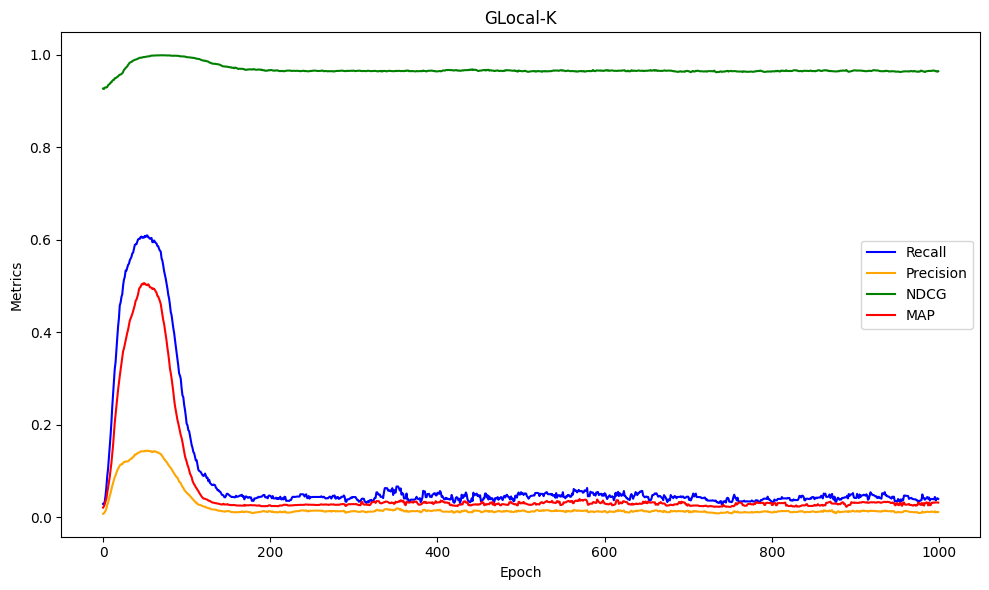

In [ ]:
import matplotlib.pyplot as plt

# Plot Recall, Precision, NDCG, MAP on the same graph
plt.figure(figsize=(10, 6))

# Recall 그래프
plt.plot(train_recall_list, label='Recall', color='blue')

# Precision 그래프
plt.plot(train_precision_list, label='Precision', color='orange')

# nDCG 그래프
plt.plot(train_ndcg_list, label='NDCG', color='green')

# MAP 그래프
plt.plot(train_map_list, label='MAP', color='red')

# 그래프 설정
plt.title('GLocal-K')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()


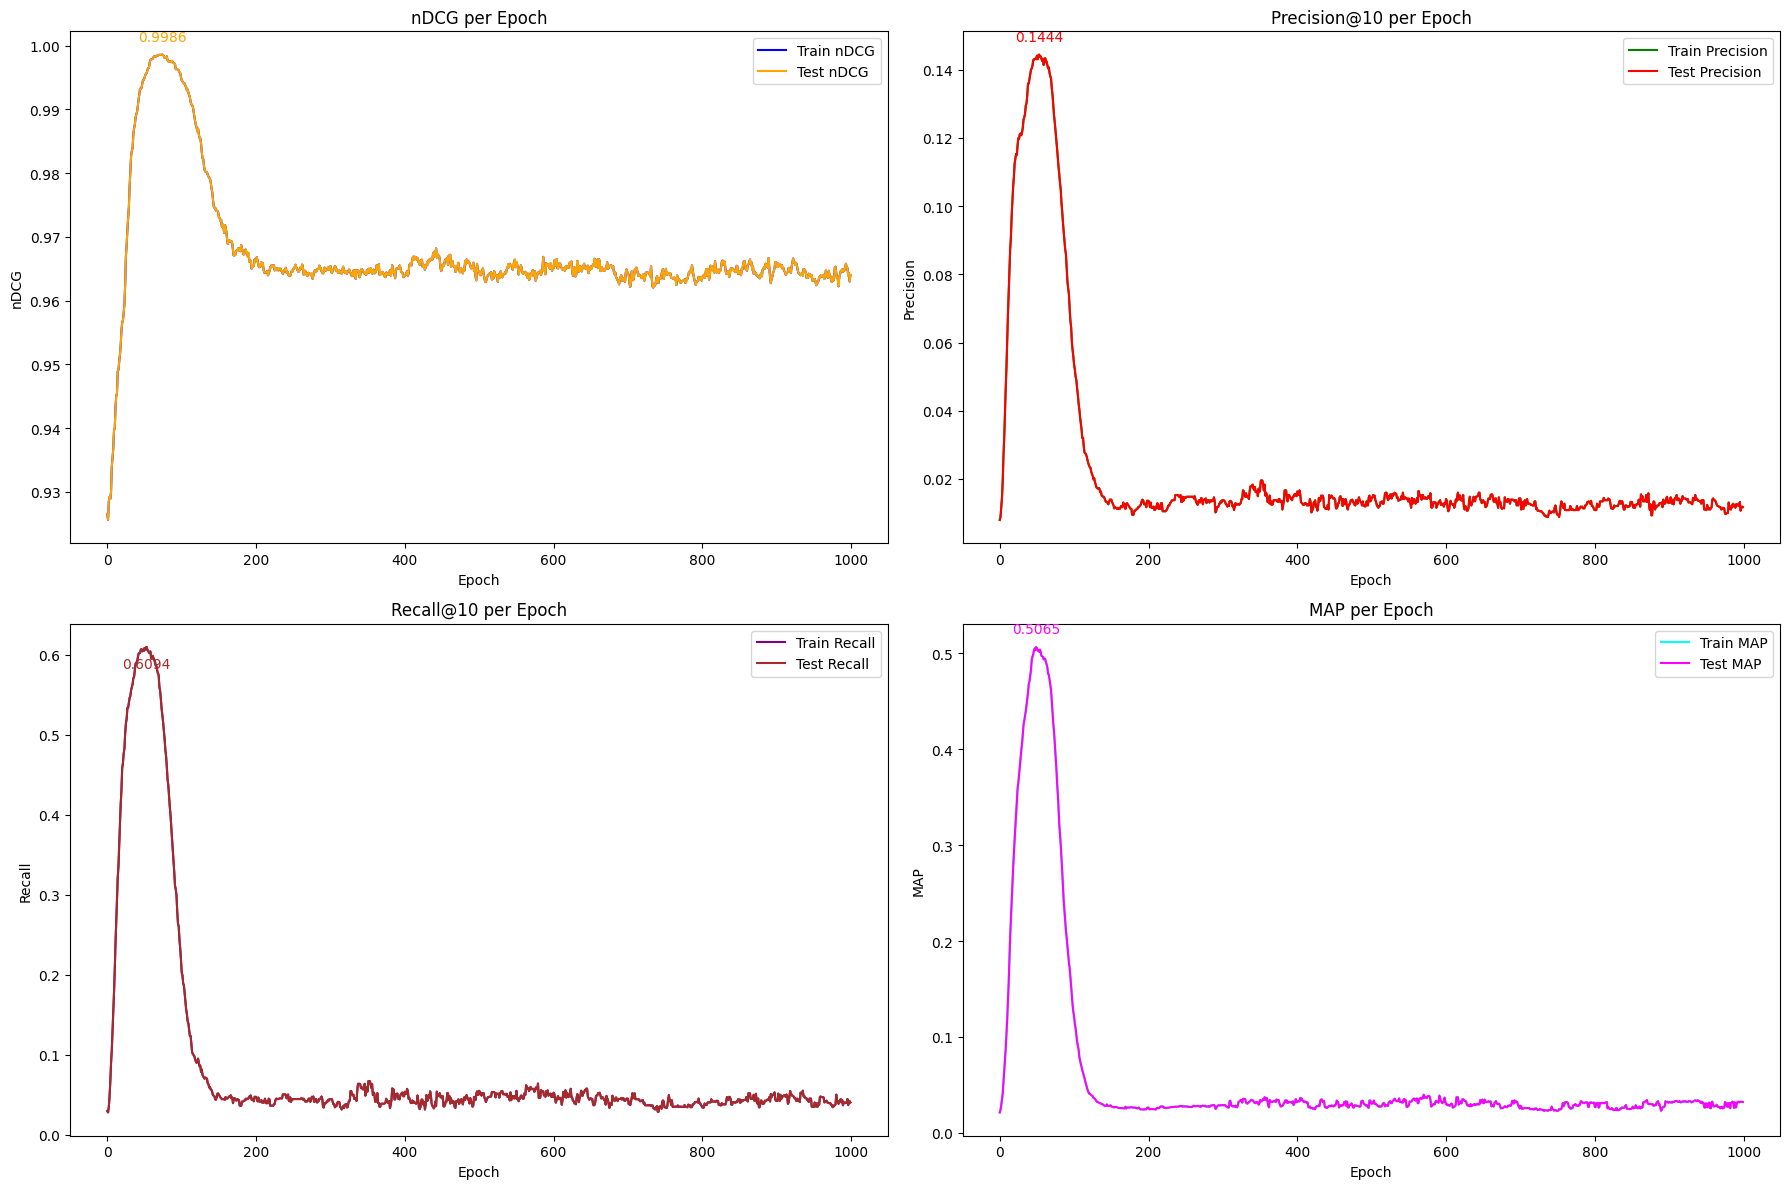

In [ ]:
import matplotlib.pyplot as plt

# Plot NDCG, Precision, Recall, MAP
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # 2개의 행, 2개의 열로 서브플롯 생성

# NDCG 그래프
axes[0, 0].plot(train_ndcg_list, label='Train nDCG', color='blue')
axes[0, 0].plot(test_ndcg_list, label='Test nDCG', color='orange')

# Test nDCG 최대값 표시
max_test_ndcg = max(test_ndcg_list)
max_test_ndcg_epoch = test_ndcg_list.index(max_test_ndcg)
axes[0, 0].annotate(f'{max_test_ndcg:.4f}', (max_test_ndcg_epoch, max_test_ndcg),
                    textcoords="offset points", xytext=(0, 10), ha='center', color='orange')

# 설정
axes[0, 0].set_title('nDCG per Epoch')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('nDCG')
axes[0, 0].legend()

# Precision 그래프
axes[0, 1].plot(train_precision_list, label='Train Precision', color='green')
axes[0, 1].plot(test_precision_list, label='Test Precision', color='red')

# Precision 최대값 표시
max_precision = max(test_precision_list)
max_precision_epoch = test_precision_list.index(max_precision)
axes[0, 1].annotate(f'{max_precision:.4f}', (max_precision_epoch, max_precision),
                    textcoords="offset points", xytext=(0, 10), ha='center', color='red')

axes[0, 1].set_title('Precision@10 per Epoch')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].legend()

# Recall 그래프
axes[1, 0].plot(train_recall_list, label='Train Recall', color='purple')
axes[1, 0].plot(test_recall_list, label='Test Recall', color='brown')

# Recall 최대값 표시
max_recall = max(test_recall_list)
max_recall_epoch = test_recall_list.index(max_recall)
axes[1, 0].annotate(f'{max_recall:.4f}', (max_recall_epoch, max_recall),
                    textcoords="offset points", xytext=(0, -15), ha='center', color='brown')

axes[1, 0].set_title('Recall@10 per Epoch')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()

# MAP 그래프
axes[1, 1].plot(train_map_list, label='Train MAP', color='cyan')
axes[1, 1].plot(test_map_list, label='Test MAP', color='magenta')

# MAP 최대값 표시
max_map = max(test_map_list)
max_map_epoch = test_map_list.index(max_map)
axes[1, 1].annotate(f'{max_map:.4f}', (max_map_epoch, max_map),
                    textcoords="offset points", xytext=(0, 10), ha='center', color='magenta')

axes[1, 1].set_title('MAP per Epoch')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MAP')
axes[1, 1].legend()

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

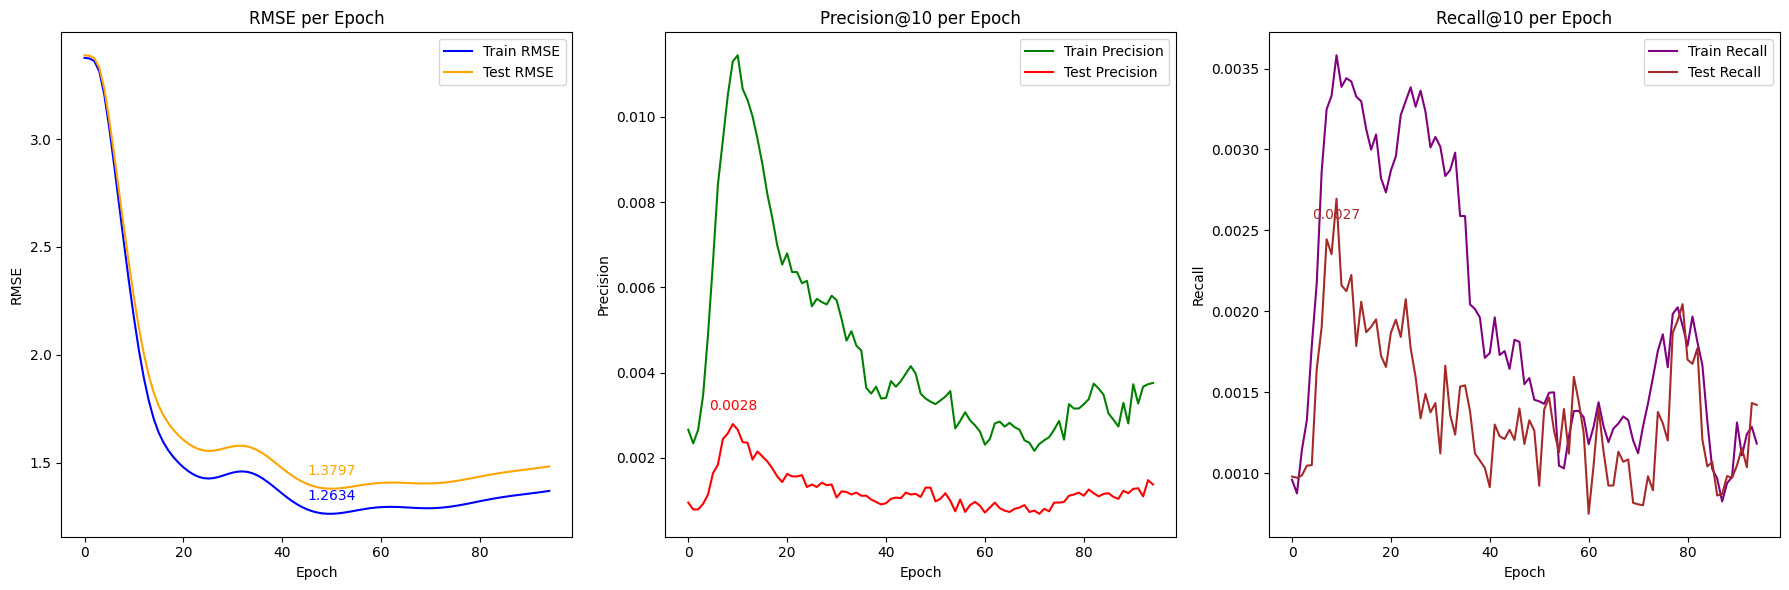

In [ ]:
import matplotlib.pyplot as plt

# Plot RMSE, Precision, Recall
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1개의 행, 3개의 열로 서브플롯 생성

# RMSE 그래프
axes[0].plot(train_rmse_list, label='Train RMSE', color='blue')
axes[0].plot(test_rmse_list, label='Test RMSE', color='orange')

# Train RMSE 최소값 표시
min_train_rmse = min(train_rmse_list)
min_train_rmse_epoch = train_rmse_list.index(min_train_rmse)
axes[0].annotate(f'{min_train_rmse:.4f}', (min_train_rmse_epoch, min_train_rmse),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='blue')

# Test RMSE 최소값 표시
min_test_rmse = min(test_rmse_list)
min_test_rmse_epoch = test_rmse_list.index(min_test_rmse)
axes[0].annotate(f'{min_test_rmse:.4f}', (min_test_rmse_epoch, min_test_rmse),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='orange')

# 설정
axes[0].set_title('RMSE per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('RMSE')
axes[0].legend()

# Precision 그래프
axes[1].plot(train_precision_list, label='Train Precision', color='green')
axes[1].plot(test_precision_list, label='Test Precision', color='red')

# Precision 최대값 표시
max_precision = max(test_precision_list)
max_precision_epoch = test_precision_list.index(max_precision)
axes[1].annotate(f'{max_precision:.4f}', (max_precision_epoch, max_precision),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='red')

axes[1].set_title('Precision@10 per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Precision')
axes[1].legend()

# Recall 그래프
axes[2].plot(train_recall_list, label='Train Recall', color='purple')
axes[2].plot(test_recall_list, label='Test Recall', color='brown')

# Recall 최대값 표시
max_recall = max(test_recall_list)
max_recall_epoch = test_recall_list.index(max_recall)
axes[2].annotate(f'{max_recall:.4f}', (max_recall_epoch, max_recall),
                 textcoords="offset points", xytext=(0, -15), ha='center', color='brown')

axes[2].set_title('Recall@10 per Epoch')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Recall')
axes[2].legend()

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

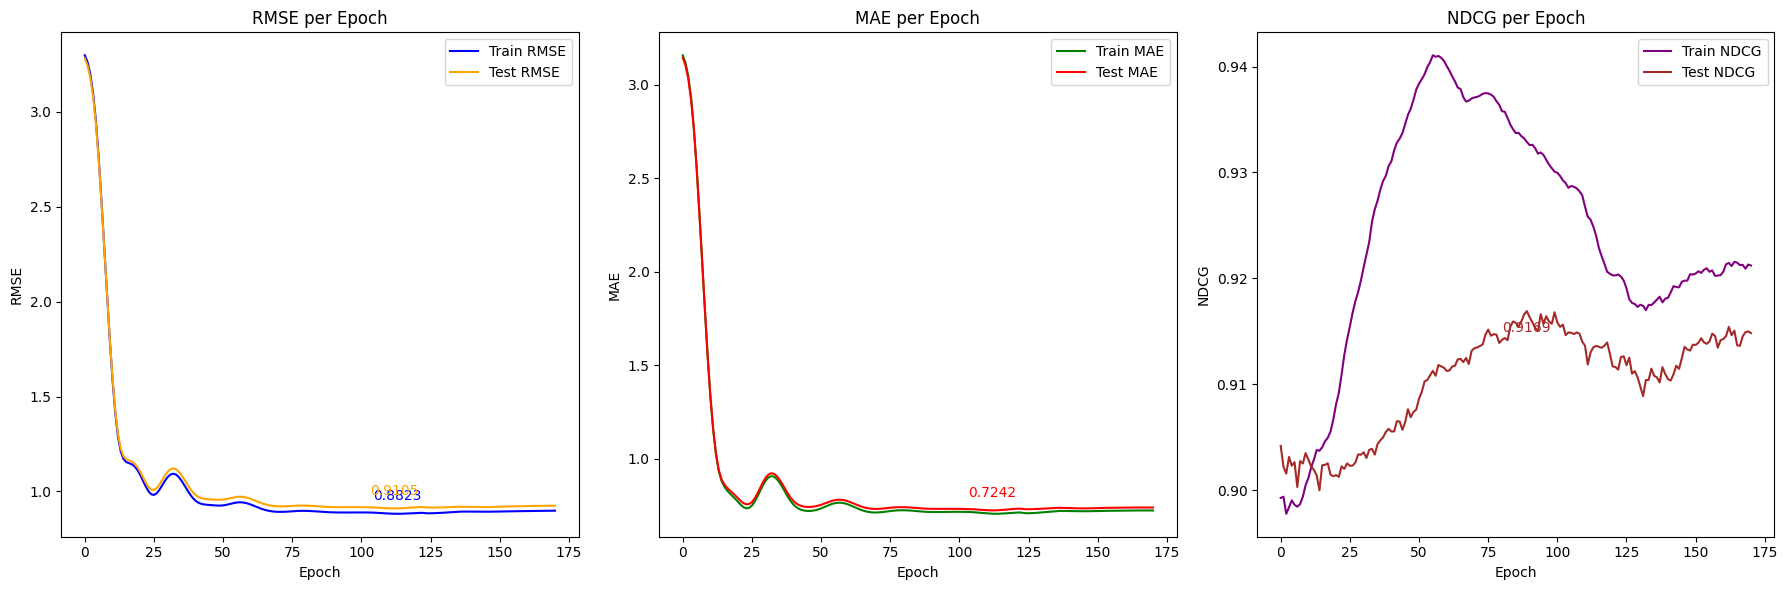

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1개의 행, 3개의 열로 서브플롯 생성

# RMSE 그래프
axes[0].plot(train_rmse_list, label='Train RMSE', color='blue')
axes[0].plot(test_rmse_list, label='Test RMSE', color='orange')

# Train RMSE 최소값 표시
min_train_rmse = min(train_rmse_list)
min_train_rmse_epoch = train_rmse_list.index(min_train_rmse)
axes[0].annotate(f'{min_train_rmse:.4f}', (min_train_rmse_epoch, min_train_rmse),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='blue')

# Test RMSE 최소값 표시
min_test_rmse = min(test_rmse_list)
min_test_rmse_epoch = test_rmse_list.index(min_test_rmse)
axes[0].annotate(f'{min_test_rmse:.4f}', (min_test_rmse_epoch, min_test_rmse),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='orange')

# 설정
axes[0].set_title('RMSE per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('RMSE')
axes[0].legend()

# MAE 그래프
axes[1].plot(train_mae_list, label='Train MAE', color='green')
axes[1].plot(test_mae_list, label='Test MAE', color='red')

# MAE 최소값 표시
min_mae = min(test_mae_list)
min_mae_epoch = test_mae_list.index(min_mae)
axes[1].annotate(f'{min_mae:.4f}', (min_mae_epoch, min_mae),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='red')

axes[1].set_title('MAE per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()

# NDCG 그래프
axes[2].plot(train_ndcg_list, label='Train NDCG', color='purple')
axes[2].plot(test_ndcg_list, label='Test NDCG', color='brown')

# NDCG 최대값 표시 (NDCG는 최대값을 찾음)
max_ndcg = max(test_ndcg_list)
max_ndcg_epoch = test_ndcg_list.index(max_ndcg)
axes[2].annotate(f'{max_ndcg:.4f}', (max_ndcg_epoch, max_ndcg),
                 textcoords="offset points", xytext=(0, -15), ha='center', color='brown')

axes[2].set_title('NDCG per Epoch')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('NDCG')
axes[2].legend()

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()